# Manuscript plots with filtered data
- using `gfp_keep` column to filter gfp/structure negative cells prior to plotting
- LIVE: flag cells with alpha-actinin protein density (μm^2) <= 75000
- FISH: flag cells with manual score of 0 (either kg/mh scores for original FISH or no_structure == 0 for other FISH)

In [1]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pingouin as pg
from scipy.stats import spearmanr
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import quilt3

from fish_morphology_code.analysis.notebook_utils import (
    DAY_18_COLOR,
    DAY_32_COLOR,
    DAY_COLOR_PALETTE,
    DAY_COLOR_PALETTE_THREE,
    BAR_PLOT_COLUMNS,
    SHORT_FEAT_NAME_MAP,
    BAR_PLOT_COLUMNS_SHORT,
    PROBE_ORDER,
    CI_EXTENT,
    FEATURE_TYPE_MAP,
    safe,
    get_regression_coef,
    boot_regression,
    ci_low,
    ci_high,
    make_reg_plot_ci_df,
    make_regression_bar_plot,
    get_pred_true,
    make_regression_scatter_plot,
    boot_spearmanr,
)

from matplotlib import cm
import fish_morphology_code.analysis.plots
from sklearn.metrics import confusion_matrix

/home/tanyag/anaconda3/envs/cardio_fish_data/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.9.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/tanyag/anaconda3/envs/cardio_fish_data/lib/python3.7/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


### Load collated data from quilt

In [2]:
#p_manuscript_data = quilt3.Package.browse(
#        "tanyasg/revised_manuscript_plots", "s3://allencell-internal-quilt"
#)

# public package
p_manuscript_data = quilt3.Package.browse(
        "aics/integrated_transcriptomics_structural_organization_hipsc_cm", "s3://allencell"
)

Loading manifest: 100%|██████████| 38305/38305 [00:01<00:00, 31260.27entries/s]


In [3]:
p_manuscript_data

(remote Package)
 └─2d_autocontrasted_fields_and_single_cells_fish_1/
 └─2d_autocontrasted_fields_and_single_cells_fish_2/
 └─2d_autocontrasted_fields_and_single_cells_fish_3/
 └─2d_autocontrasted_fields_and_single_cells_fish_4/
 └─2d_autocontrasted_single_cell_features_fish_1/
 └─2d_autocontrasted_single_cell_features_fish_2/
 └─2d_autocontrasted_single_cell_features_fish_3/
 └─2d_autocontrasted_single_cell_features_fish_4/
 └─2d_nonstructure_fields/
 └─2d_nonstructure_single_cell_features/
 └─2d_nuclear_masks/
 └─2d_segmented_fields_fish_1/
 └─2d_segmented_fields_fish_2/
 └─2d_segmented_fields_fish_3/
 └─2d_segmented_fields_fish_4/
 └─3d_actn2_segmentation/
 └─README.md
 └─automated_local_and_global_structure_fish_1/
 └─automated_local_and_global_structure_fish_2/
 └─automated_local_and_global_structure_fish_3/
 ...

In [4]:
p_manuscript_data["revised_manuscript_plots"].fetch(
    "figure_data"
)

Copying objects: 100%|██████████| 16.1M/16.1M [00:01<00:00, 9.67MB/s]


(local Package)
 └─README.md
 └─data.csv

In [5]:
SAVE=True

if SAVE:
    SAVE_DIR = Path("./plots")
    SAVE_DIR.mkdir(parents=True, exist_ok=True)

    save_dir_pngs = SAVE_DIR/"pngs"
    save_dir_svgs = SAVE_DIR/"svgs"
    save_dir_pngs.mkdir(parents=True, exist_ok=True)
    save_dir_svgs.mkdir(parents=True, exist_ok=True)

In [6]:
replate_groups = {
    "2019-05-17": 1,
    "2019-05-21": 2,
    "2019-05-24": 3,
    "2019-06-04": 4,
    "2020-06-07": 5,
    "2020-08-28": 6,
    "2020-09-08": 7
}

#### Load collated data

In [7]:
#df = pd.read_csv("../20201110_collate_revised_data/20201124_revised_plot_data.csv")
df = pd.read_csv("figure_data/data.csv")

/home/tanyag/anaconda3/envs/cardio_fish_data/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Add replate groups

In [8]:
df["replate_group"] = [replate_groups[x] for x in df.replate_date]

### Filter out gfp negative scores
- using `gfp_keep` column
- fish are filtered based on manual score of 0; meaning no gfp/structure visible
- live are filtered based on protein density threshold of 75000 (after converting to micrometers squared)

In [9]:
df = df[df.gfp_keep].copy().reset_index(drop=True)

### Figure 2F Heatmap of fraction area per class, cells sorted by fraction area of organized z-disc

In [10]:
feat_cols = [
    "Cell area (μm^2)",
    "Cell aspect ratio",
    "Fraction cell area background",
    "Fraction cell area diffuse/other",
    "Fraction cell area fibers",
    "Fraction cell area disorganized puncta",
    "Fraction cell area organized puncta",
    "Fraction cell area organized z-disks",
    "Max coefficient var",
    "Peak height",
    "Peak distance (μm)",
    "Cell age"
]

In [11]:
yvars_set1 = [
    "Fraction cell area background",
    "Fraction cell area diffuse/other",
    "Fraction cell area disorganized puncta",
    "Fraction cell area fibers",
    "Fraction cell area organized puncta",
    "Fraction cell area organized z-disks"
]

viridis = cm.get_cmap('viridis', len(yvars_set1))

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


(6193, 66)
(1806, 66)
(4942, 66)


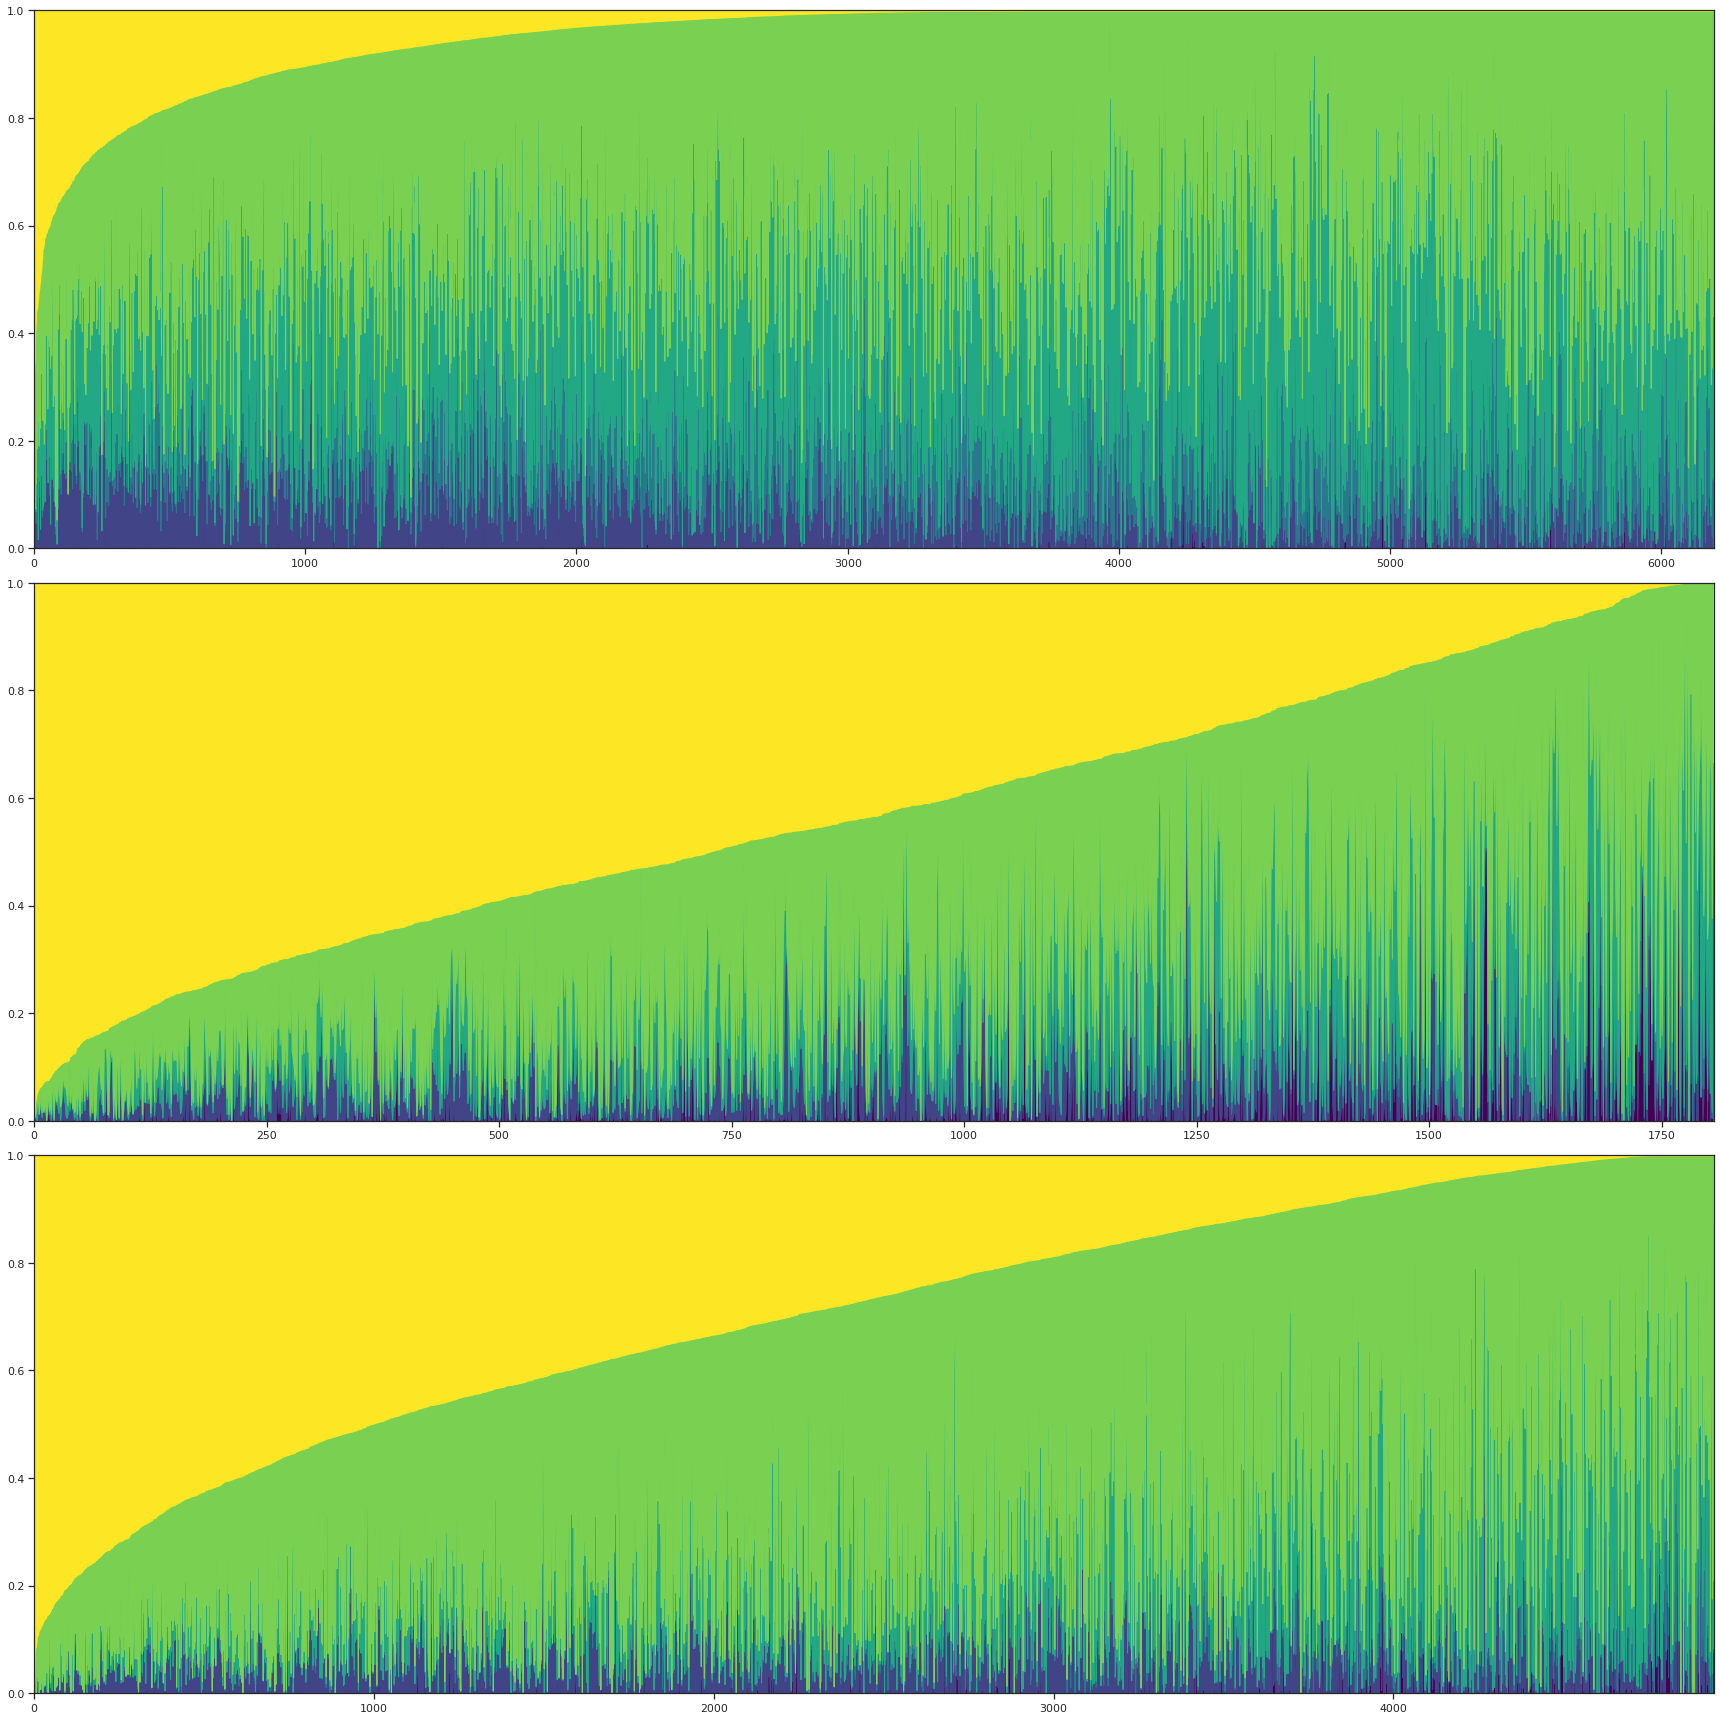

In [12]:
ranking_variable = 'Fraction cell area organized z-disks'
    
fig, ax = plt.subplots(3,1, figsize=(24,24))
for id_age, (age, df_age) in enumerate(df[df.Type=="FISH"].groupby("Cell age")):
    df_age = df_age.sort_values(ranking_variable, ascending=False)
    print(df_age.shape)

    x = np.arange(df_age.shape[0])
    y = np.zeros(x.shape, dtype = np.float32)

    ax[id_age].set_ylim(0,1)
    ax[id_age].set_xlim(0,x.size)

    for id_yvar, yvar in enumerate(yvars_set1):
        y_sup = y + df_age[yvar].values
        ax[id_age].fill_between(x[:],y1=y,y2=y_sup, color=viridis(id_yvar/len(yvars_set1)))
        y = y_sup
        
plt.tight_layout()
if SAVE:
    plt.savefig(f'heatmap_rankby_{ranking_variable}.png')
    plt.savefig(save_dir_pngs/f'fig_2f_heatmap_rankby_{ranking_variable}.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/f'fig_2f_heatmap_rankby_{ranking_variable}.svg', format="svg", bbox_inches = "tight")
plt.show()

### Figure 3E Max coefficient of variation vs. Fraction of cell organized z-disk
Plot old and new/bonus fish -> plate -013, -014, -171, -172

In [13]:
df[df.Dataset.isin(["OldFish", "NewFish"])].shape

(11135, 66)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


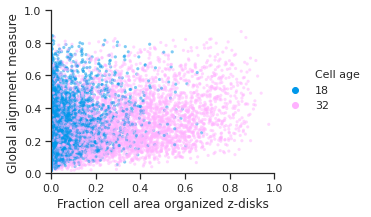

In [14]:
plt.figure(figsize=(4, 3))

plot_org_vs_stripes = sns.scatterplot(
    data=df[df.Dataset.isin(["OldFish", "NewFish"])].sample(frac=1, replace=False).reset_index(drop=True),
    x="Fraction cell area organized z-disks",
    y="Max coefficient var",
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    linewidth=0,
    alpha = 0.5,
    s=10,
)
plot_org_vs_stripes.set(ylabel="Global alignment measure");
plot_org_vs_stripes.set(xlim=(0, 1));
plot_org_vs_stripes.set(ylim=(0, 1));

handles, _ = plot_org_vs_stripes.get_legend_handles_labels()
plot_org_vs_stripes.legend(handles, ["Cell age", "18", "32"], bbox_to_anchor=(1.0, 0.7), frameon=False)
sns.despine()

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_3g_regular_stripes_vs_global_alignment.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_3g_regular_stripes_vs_global_alignment.svg', format="svg", bbox_inches = "tight")

#### Old Fish cells with manual scores used for regression model

In [15]:
df_old = df[df.Dataset=="OldFish"].copy()

all_good_scores = (df_old.kg_structure_org_score > 0) & (df_old.mh_structure_org_score > 0)
df_old = df_old[all_good_scores]
df_old.shape

(4823, 66)

### Figure 4B Cos regression coefficients bar graph

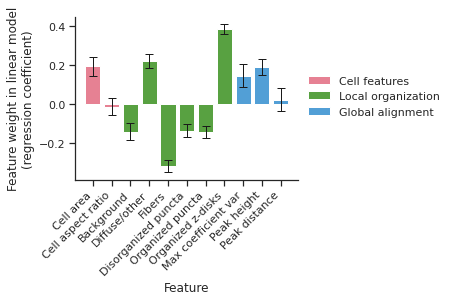

In [16]:
df_boot_reg = boot_regression(
    df_old,
    N=1000,
    X_cols=BAR_PLOT_COLUMNS,
    y_col="Expert structural annotation score (mean)",
    weight_col="Expert structural annotation score (mean)",
)

reg_plot_ci_df = make_reg_plot_ci_df(df_boot_reg)

fig_bar, ax_bar = make_regression_bar_plot(reg_plot_ci_df, title="")

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig_4b_linear_model_feature_importances.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig_4b_linear_model_feature_importances.svg', format="svg", bbox_inches = "tight")


Save feature weights for Supplemental Table 4

In [18]:
#reg_plot_ci_df.to_csv("regression_feature_weights_20201207.csv", index=False)

### Figure 4C expert (both) vs. COS confusion matrices

In [17]:
df_expert = df[
    (df.kg_structure_org_score > 0) & (df.mh_structure_org_score > 0)
]

df_expert['Combined organizational score (rounded)'] = np.round(np.clip(df_expert['Combined organizational score'], 1,5))

df_expert_melt = df_expert.melt(
    value_vars=["kg_structure_org_score", "mh_structure_org_score"],
    id_vars=[c for c in df_expert.columns if c not in ["kg_structure_org_score", "mh_structure_org_score"]],
    var_name="Expert annotator",
    value_name="Expert score"
)
df_expert_melt["Expert annotator"] = df_expert_melt["Expert annotator"].apply(lambda x: x.split("_")[0])
df_expert_melt["Expert score"].unique()

assert np.all(sorted(df_expert_melt["Expert score"].unique()) == np.array([1,2,3,4,5]))
assert np.all(sorted(df_expert["kg_structure_org_score"].unique()) == np.array([1,2,3,4,5]))
assert np.all(sorted(df_expert["mh_structure_org_score"].unique()) == np.array([1,2,3,4,5]))

/home/tanyag/anaconda3/envs/cardio_fish_data/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### Get spearman correlations
We will be showing confusion matices w/ both exprt scores vs. combined organizational score

In [18]:
df_corrs_exp_both_cos = df_expert_melt.groupby(
    "Dataset"
)[
    [
        "Expert score",
        'Combined organizational score'
    ]
].corr(method="spearman").drop(
    columns=['Expert score']
).rename_axis(
    ['Dataset', 'column']
).drop(
    "Combined organizational score",
    level='column'
).reset_index(
).drop(
    columns="column"
).rename(columns={"Combined organizational score":"Expert-COS correlation (both)"})

df_corrs_exp_mean_cos = df_expert.groupby(
    "Dataset"
)[
    [
        "Expert structural annotation score (mean)",
        'Combined organizational score'
    ]
].corr(method="spearman").drop(
    columns=['Expert structural annotation score (mean)']
).rename_axis(
    ['Dataset', 'column']
).drop(
    "Combined organizational score",
    level='column'
).reset_index(
).drop(
    columns="column"
).rename(columns={"Combined organizational score":"Expert-COS correlation (mean)"})

df_corrs_exp_exp = df_expert.groupby(
    "Dataset"
)[
    [
        "kg_structure_org_score",
        "mh_structure_org_score"
    ]
].corr(method="spearman").drop(
    columns=['kg_structure_org_score']
).rename_axis(
    ['Dataset', 'column']
).drop(
    "mh_structure_org_score",
    level='column'
).reset_index(
).drop(
    columns="column"
).rename(columns={"mh_structure_org_score":"Expert-Expert correlation"})

df_score_corrs = df_corrs_exp_exp.merge(df_corrs_exp_mean_cos).merge(df_corrs_exp_both_cos)
df_score_corrs

Dataset  Expert-Expert correlation  Expert-COS correlation (mean)  \
0     Live                   0.750072                       0.755990   
1  NewFish                   0.723585                       0.733184   
2  OldFish                   0.654228                       0.744936   

   Expert-COS correlation (both)  
0                       0.673317  
1                       0.632085  
2                       0.665655

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


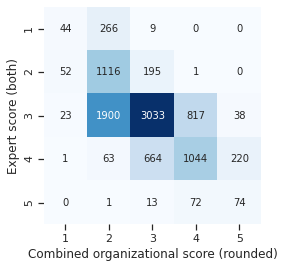

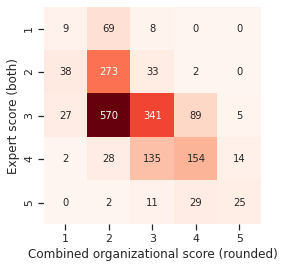

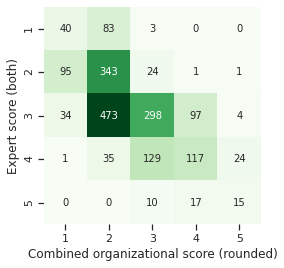

In [19]:
for dataset in df_expert.Dataset.unique():

    conf_mat = confusion_matrix(
        df_expert_melt[df_expert_melt.Dataset==dataset]['Expert score'],
        df_expert_melt[df_expert_melt.Dataset==dataset]['Combined organizational score (rounded)']
    )

    data_colors = {"OldFish": "Blues", "NewFish": "Reds", "Live": "Greens"}
    
    dims = (4, 4)
    fig, ax = plt.subplots(figsize=dims)
    conf_mat_plot = sns.heatmap(
        conf_mat,
        annot=True,
        fmt="d",
        square=True,
        cmap=data_colors[dataset],
        cbar=False,
    )

    conf_mat_plot.set(
        xlabel='Combined organizational score (rounded)',
        ylabel='Expert score (both)',
    );
    conf_mat_plot.set_xticklabels([1,2,3,4,5])
    conf_mat_plot.set_yticklabels([1,2,3,4,5]);

    # save png and svg
    if SAVE:
        plt.savefig(save_dir_pngs/f"fig4c_expert_both_COS_conf_mat_{dataset}.png", dpi=300, bbox_inches = "tight")
        plt.savefig(save_dir_svgs/f"fig4c_expert_both_COS_conf_mat_{dataset}.svg", format="svg", bbox_inches = "tight")

### Figure 4D COS histogram by expert score

In [20]:
def group_human_scores(df):
    df["Expert structural annotation score (roundup)"] = np.ceil(
        df["Expert structural annotation score (mean)"]
    ).astype(int)
    df["Expert structural annotation score (grouped)"] = df[
        "Expert structural annotation score (roundup)"
    ].map({1: "1-2", 2: "1-2", 3: "3", 4: "4-5", 5: "4-5"})
    return df

In [21]:
df_expert = group_human_scores(df_expert)

/home/tanyag/anaconda3/envs/cardio_fish_data/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/tanyag/anaconda3/envs/cardio_fish_data/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [22]:
df_expert.shape

(6677, 69)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


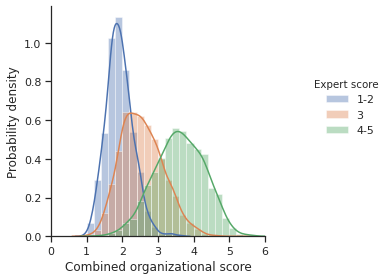

In [23]:
bins = np.linspace(0,6,31)

g = sns.FacetGrid(
    df_expert,
    hue='Expert structural annotation score (grouped)',
    hue_order=["1-2", "3", "4-5"],
    height=4
)
g = g.map(
    sns.distplot,
    'Combined organizational score',
    bins=bins
).add_legend()

g.set(xlim=(0, 6));
g._legend.set(bbox_to_anchor=(0.75, 0.6))
g._legend.set_title("Expert score  ")
g.set(ylabel='Probability density');

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig4d_linear_model_distplot_grouped_by_human_score.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig4d_linear_model_distplot_grouped_by_human_score.svg', format="svg", bbox_inches = "tight")

### Figure 4E Histograms of Fraction cell area organized z-disks and Fraction fibers by grouped org score

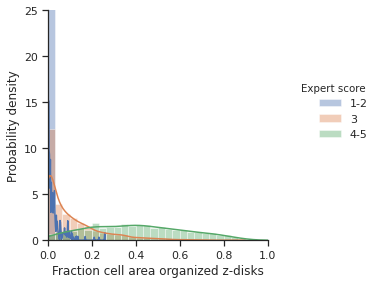

In [24]:
bins = np.linspace(0,1,31)

g = sns.FacetGrid(
    df_expert,
    hue="Expert structural annotation score (grouped)",
    hue_order=["1-2", "3", "4-5"],
    height=4
)
g = g.map(
    sns.distplot,
    'Fraction cell area organized z-disks',
    bins=bins,
).add_legend()

g.set(xlim=(0, 1));
g.set(ylim=(0, 25));
g._legend.set(bbox_to_anchor=(0.75, 0.6))
g._legend.set_title("Expert score      ")

g.set(ylabel='Probability density');

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig4e_regular_stripes_distplot_grouped_by_human_score.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig4e_regular_stripes_distplot_grouped_by_human_score.svg', format="svg", bbox_inches = "tight")

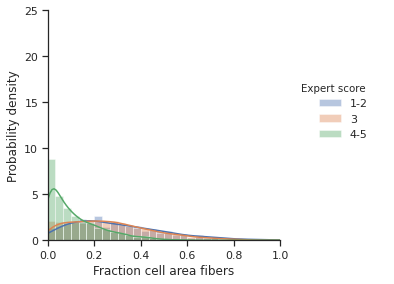

In [25]:
bins = np.linspace(0,1,31)

g = sns.FacetGrid(
    df_expert,
    hue="Expert structural annotation score (grouped)",
    hue_order=["1-2", "3", "4-5"],
    height=4
)
g = g.map(
    sns.distplot,
    'Fraction cell area fibers',
    bins=bins,
).add_legend()

g.set(xlim=(0, 1));
g.set(ylim=(0, 25));
g._legend.set(bbox_to_anchor=(0.75, 0.6))
g._legend.set_title("Expert score      ")

g.set(ylabel='Probability density');

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig4e_fibers_distplot_grouped_by_human_score.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig4e_fibers_distplot_grouped_by_human_score.svg', format="svg", bbox_inches = "tight")

### Figure 4F COS distribution in live data by cell age

In [26]:
df[df.Dataset=="Live"].shape

(18045, 66)

In [27]:
DAY_18_COLOR = "#0098EA"
DAY_32_COLOR = "#FFB2FF"
DAY_25_COLOR = "#9D02D7"
DAY_COLOR_PALETTE_THREE = sns.color_palette([DAY_18_COLOR, DAY_25_COLOR, DAY_32_COLOR])

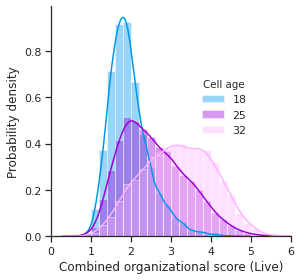

In [28]:
bins = np.linspace(0,6,31)

g = sns.FacetGrid(
    df[df.Dataset=="Live"],
    hue="Cell age",
    hue_order=[18, 25, 32],
    height=4,
    palette=DAY_COLOR_PALETTE_THREE
)
g = g.map(
    sns.distplot,
    'Combined organizational score',
    bins=bins
).add_legend()

g.set(xlim=(0, 6));
g._legend.set(bbox_to_anchor=(0.75, 0.6))
g.set(ylabel='Probability density', xlabel='Combined organizational score (Live)');

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig4f_live_cos_distplot_grouped_by_cell_age.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig4f_live_cos_distplot_grouped_by_cell_age.svg', format="svg", bbox_inches = "tight")

### Figure 5B ACTN2 correlations (transcript, protein, COS)

First calc ACTN2 protein density

In [29]:
df["alpha-actinin protein intensity (density)"] = df[
    "alpha-actinin protein intensity (sum)"
]/df["Cell area (μm^2)"]

df["alpha-actinin protein intensity (density, background subtracted)"] = df[
    "alpha-actinin protein intensity (sum, background subtracted)"
]/df["Cell area (μm^2)"]

In [30]:
df[(df.ge_wellID.isin(["5500000075-B3", "5500000322-B2", "5500000323-B2", "5500000322-B5", "5500000323-B5"]))][["alpha-actinin protein intensity (density, background subtracted)", "Combined organizational score"]].corr(method="spearman")

alpha-actinin protein intensity (density, background subtracted)  \
alpha-actinin protein intensity (density, backg...                                            1.00000                  
Combined organizational score                                                                 0.16352                  

                                                    Combined organizational score  
alpha-actinin protein intensity (density, backg...                        0.16352  
Combined organizational score                                             1.00000

#### Make df w/ all live and fish actn2 wells

In [31]:
actn2_df = df[(df.ge_wellID.isin(["5500000075-B3", "5500000322-B2", "5500000323-B2"])) | (df.Dataset=="Live")].copy().reset_index(drop=True)

In [32]:
actn2_df["ACTN2 (count/μm^2)"].isna().sum()

18045

In [33]:
actn2_df.shape

(19076, 68)

In [34]:
actn2_df[actn2_df.Type=="FISH"]["ge_wellID"].unique()

array(['5500000075-B3', '5500000322-B2', '5500000323-B2'], dtype=object)

### Figure 5B all 3 ACTN2 d25 datasets combined, protein density vs. ACTN2 transcript density

In [35]:
actn2_df[actn2_df.Type=="FISH"][["alpha-actinin protein intensity (density, background subtracted)", "ACTN2 (count/μm^2)"]].corr(method="spearman")

alpha-actinin protein intensity (density, background subtracted)  \
alpha-actinin protein intensity (density, backg...                                           1.000000                  
ACTN2 (count/μm^2)                                                                           0.308625                  

                                                    ACTN2 (count/μm^2)  
alpha-actinin protein intensity (density, backg...            0.308625  
ACTN2 (count/μm^2)                                            1.000000

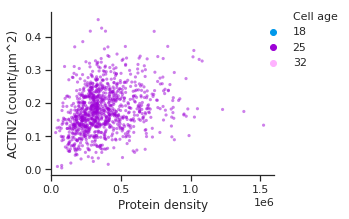

In [36]:
plt.figure(figsize=(4, 3))

p_scatter = sns.scatterplot(
    data=actn2_df[actn2_df.Type=="FISH"].sample(frac=1, replace=False).reset_index(drop=True),
    x="alpha-actinin protein intensity (density, background subtracted)",
    y="ACTN2 (count/μm^2)",
    hue="Cell age",
    hue_order=[18, 25, 32],
    palette=DAY_COLOR_PALETTE_THREE,
    s=10,
    alpha=0.5,
    linewidth=0,
)
p_scatter.set(xlabel="Protein density");
p_scatter.set(xlim=(0, 1600000));

handles, _ = p_scatter.get_legend_handles_labels()
p_scatter.legend(handles, ["Cell age", "18", "25", "32"], bbox_to_anchor=(0.9, 0.6), frameon=False)
sns.despine()

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig5b_fixed_actn2_protein_transcript_density.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig5b_fixed_actn2_protein_transcript_density.svg', format="svg", bbox_inches = "tight")

### Figure 5C fixed ACTN2 COS vs. protein density

In [37]:
actn2_df[actn2_df.Type=="FISH"][["Combined organizational score", "alpha-actinin protein intensity (density, background subtracted)"]].corr(method="spearman")

Combined organizational score  \
Combined organizational score                                            1.000000   
alpha-actinin protein intensity (density, backg...                       0.108311   

                                                    alpha-actinin protein intensity (density, background subtracted)  
Combined organizational score                                                                0.108311                 
alpha-actinin protein intensity (density, backg...                                           1.000000

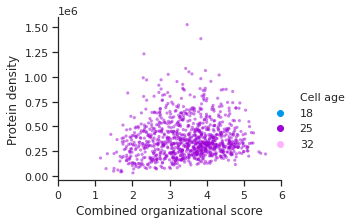

In [38]:
plt.figure(figsize=(4, 3))

p_scatter = sns.scatterplot(
    data=actn2_df[actn2_df.Type=="FISH"].dropna(subset=["alpha-actinin protein intensity (sum, background subtracted)"]).sample(frac=1, replace=False).reset_index(drop=True),
    x="Combined organizational score",
    y="alpha-actinin protein intensity (density, background subtracted)",
    hue="Cell age",
    hue_order=[18, 25, 32],
    palette=DAY_COLOR_PALETTE_THREE,
    s=10,
    alpha=0.5,
    linewidth=0,
)
p_scatter.set(ylabel="Protein density");
p_scatter.set(xlim=(0, 6));

handles, _ = p_scatter.get_legend_handles_labels()
p_scatter.legend(handles, ["Cell age", "18", "25", "32"], bbox_to_anchor=(0.9, 0.6), frameon=False)
sns.despine()

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig5c_fixed_actn2_cos_protein_density.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig5c_fixed_actn2_cos_protein_density.svg', format="svg", bbox_inches = "tight")

### Figure 5D all 3 ACTN2 d25 datasets combined, COS vs. ACTN2 transcript density

In [39]:
actn2_df[actn2_df.Type=="FISH"][["Combined organizational score", "ACTN2 (count/μm^2)"]].corr(method="spearman")

Combined organizational score  \
Combined organizational score                       1.000000   
ACTN2 (count/μm^2)                                  0.074448   

                               ACTN2 (count/μm^2)  
Combined organizational score            0.074448  
ACTN2 (count/μm^2)                       1.000000

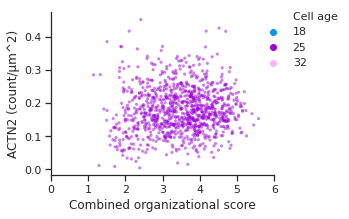

In [40]:
plt.figure(figsize=(4, 3))

p_scatter = sns.scatterplot(
    data=actn2_df[actn2_df.Type=="FISH"].dropna(subset=["alpha-actinin protein intensity (sum, background subtracted)"]).sample(frac=1, replace=False).reset_index(drop=True),
    x="Combined organizational score",
    y="ACTN2 (count/μm^2)",
    hue="Cell age",
    hue_order=[18, 25, 32],
    palette=DAY_COLOR_PALETTE_THREE,
    s=10,
    alpha=0.5,
    linewidth=0,
)
p_scatter.set(ylabel="ACTN2 (count/μm^2)");
p_scatter.set(xlim=(0, 6));

handles, _ = p_scatter.get_legend_handles_labels()
p_scatter.legend(handles, ["Cell age", "18", "25", "32"], bbox_to_anchor=(0.9, 0.6), frameon=False)
sns.despine()

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig5d_fixed_actn2_cos_transcript_density.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig5d_fixed_actn2_cos_transcript_density.svg', format="svg", bbox_inches = "tight")

### Figure 5E Live COS vs. protein density

In [41]:
actn2_df[actn2_df.Type=="Live"][
    ["Combined organizational score", "alpha-actinin protein intensity (density, background subtracted)"]
].corr(method="spearman")

Combined organizational score  \
Combined organizational score                                            1.000000   
alpha-actinin protein intensity (density, backg...                       0.240836   

                                                    alpha-actinin protein intensity (density, background subtracted)  
Combined organizational score                                                                0.240836                 
alpha-actinin protein intensity (density, backg...                                           1.000000

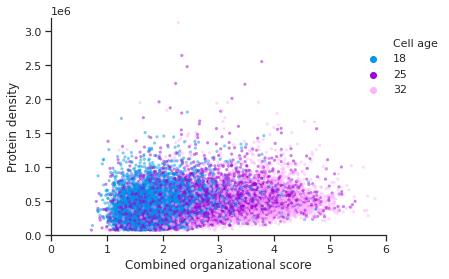

In [42]:
p_scatter = sns.scatterplot(
    data=actn2_df[actn2_df.Type=="Live"].dropna(subset=["alpha-actinin protein intensity (sum, background subtracted)"]).sample(frac=1, replace=False).reset_index(drop=True),
    x="Combined organizational score",
    y="alpha-actinin protein intensity (density, background subtracted)",
    hue="Cell age",
    hue_order=[18, 25, 32],
    palette=DAY_COLOR_PALETTE_THREE,
    s=10,
    alpha=0.5,
    linewidth=0,
)
p_scatter.set(ylabel="Protein density")
p_scatter.set(xlim=(0, 6))
p_scatter.set(ylim=(0, 3.2e6))

handles, _ = p_scatter.get_legend_handles_labels()
p_scatter.legend(handles, ["Cell age", "18", "25", "32"], bbox_to_anchor=(0.9, 0.6), frameon=False)
sns.despine()

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig5e_live_cos_protein_density.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig5e_live_cos_protein_density.svg', format="svg", bbox_inches = "tight")

In [43]:
actn2_df[actn2_df.Type=="Live"].groupby("Cell age")[
    ["Combined organizational score", "alpha-actinin protein intensity (density, background subtracted)"]
].corr(method="spearman")

Combined organizational score  \
Cell age                                                                                     
18       Combined organizational score                                            1.000000   
         alpha-actinin protein intensity (density, backg...                       0.185625   
25       Combined organizational score                                            1.000000   
         alpha-actinin protein intensity (density, backg...                       0.335849   
32       Combined organizational score                                            1.000000   
         alpha-actinin protein intensity (density, backg...                       0.304271   

                                                             alpha-actinin protein intensity (density, background subtracted)  
Cell age                                                                                                                       
18       Combined organizational score                                                                0.185625                 
         alpha-actinin protein intensity (density, backg...                                           1.000000                 
25       Combined organizational score                                                                0.335849                 
         alpha-actinin protein intensity (density, backg...                                           1.000000                 
32       Combined organizational score                                                                0.304271                 
         alpha-actinin protein intensity (density, backg...                                           1.000000

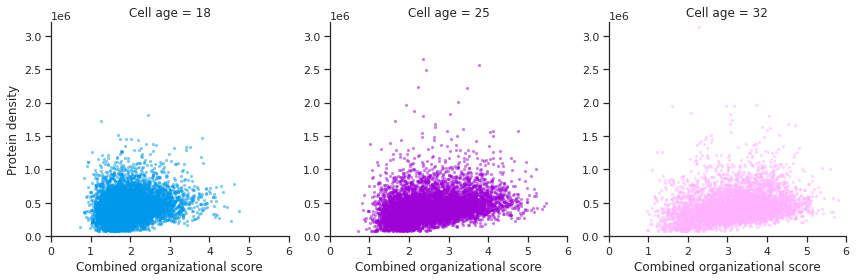

In [44]:
g = sns.FacetGrid(
    actn2_df[actn2_df.Type=="Live"].dropna(subset=["alpha-actinin protein intensity (sum, background subtracted)"]).sample(frac=1, replace=False).reset_index(drop=True),    col="Cell age",
    col_wrap=3,
    hue="Cell age",
    hue_order=[18, 25, 32],
    palette=DAY_COLOR_PALETTE_THREE,
    sharex=True,
    xlim=(0, 6),
    ylim=(0, 3.2e6),
    sharey=False,
    height=4.0,
    aspect=1.0,
)
g.map(
    sns.scatterplot,
    "Combined organizational score",
    "alpha-actinin protein intensity (density, background subtracted)",
    s=10,
    alpha=0.5,
    linewidth=0,
);

g.set_axis_labels(y_var="Protein density")

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig5e_live_cos_protein_density_cell_age.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig5e_live_cos_protein_density_cell_age.svg', format="svg", bbox_inches = "tight")

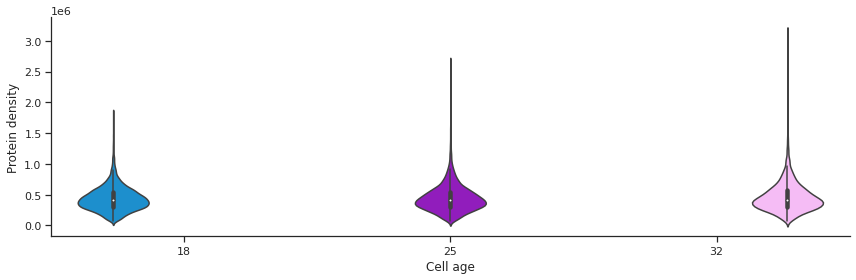

In [45]:
#plt.figure(figsize=(2,2))

p_viol = sns.catplot(
    kind="violin",
    split=False,
    data=actn2_df[actn2_df.Type=="Live"].dropna(subset=["alpha-actinin protein intensity (sum, background subtracted)"]).reset_index(drop=True),
    x="Cell age",
    order=[18, 25, 32],
    y="alpha-actinin protein intensity (density, background subtracted)",
    hue="Cell age",
    hue_order=[18, 25, 32],
    palette=DAY_COLOR_PALETTE_THREE,
    height=4,
    aspect=3,
)
sns.despine()
plt.ylabel("Protein density")

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig5e_live_protein_density_dist_cell_age.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig5e_live_protein_density_dist_cell_age.svg', format="svg", bbox_inches = "tight")

### Define bootstrap corr data wrangling function for ebars on bar plots

In [46]:
def pack_complex_corr_col(arg_df, arg_col1, arg_col2, outcol="Corr"):
    arg_df[outcol] = arg_df.apply(
        lambda row: np.complex(row[arg_col1], row[arg_col2]), axis="columns"
    )

def spearman_on_complex_col(tuple_col):
    return spearmanr(np.real(tuple_col), np.imag(tuple_col))[0]

### Figure 5F correlation bar plot (fixed, live -> COS, protein density, transcript density

#### COS vs protein density (fixed ACTN2 and live) Protein-> structure

/home/tanyag/anaconda3/envs/cardio_fish_data/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


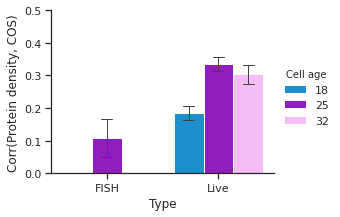

In [47]:
pack_complex_corr_col(
    actn2_df,
    "Combined organizational score",
    "alpha-actinin protein intensity (density, background subtracted)",
    outcol="Corr(Protein density, COS)",
)

plt.figure(figsize=(4,3))
p_bar = sns.barplot(
    data=actn2_df.dropna(subset=["Combined organizational score", "alpha-actinin protein intensity (sum, background subtracted)"]),
    x="Type",
    y="Corr(Protein density, COS)",
    hue="Cell age",
    hue_order=[18, 25, 32],
    palette=DAY_COLOR_PALETTE_THREE,
    estimator=spearman_on_complex_col,
    n_boot=1000,
    ci=95,
    errwidth=1,
    capsize=0.1,
);

p_bar.set(ylim=(0, 0.5));

sns.despine();

plt.legend(title="Cell age", bbox_to_anchor=(1.0, 0.7), frameon=False);

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig5f_fish_plus_live_cos_protein_density_corr.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig5f_fish_plus_live_cos_protein_density_corr.svg', bbox_inches = "tight")

In [189]:
for data_type in actn2_df.Type.unique():
    for age in actn2_df["Cell age"].unique():
        corr_boots = sns.algorithms.bootstrap(
                    actn2_df[(actn2_df.Type==data_type) & (actn2_df["Cell age"]==age)].dropna(subset=["Combined organizational score", "alpha-actinin protein intensity (sum, background subtracted)"])["Corr(Protein density, COS)"],
                    n_boot=1000,
                    func=spearman_on_complex_col
                )

        spearman_r = np.mean(corr_boots)
        ci_interval = sns.utils.ci(corr_boots, which=95)
        print(f"{data_type} Day: {age} spearman R: {spearman_r} ci_lower: {ci_interval[0]}, ci_upper: {ci_interval[1]}")

FISH Day: 25 spearman R: 0.10745600551174075 ci_lower: 0.04853750702382396, ci_upper: 0.1689329395762009
FISH Day: 18 spearman R: nan ci_lower: nan, ci_upper: nan
FISH Day: 32 spearman R: nan ci_lower: nan, ci_upper: nan
Live Day: 25 spearman R: 0.33617996853434945 ci_lower: 0.3141915534115993, ci_upper: 0.3589578328727101
Live Day: 18 spearman R: 0.1856046941177418 ci_lower: 0.1631478806185072, ci_upper: 0.20689623400685114
Live Day: 32 spearman R: 0.3039536259361432 ci_lower: 0.2768602540575546, ci_upper: 0.3317943108008309


#### COrrelation COS. vs transcript density (fixed only) Trascript -> structure

/home/tanyag/anaconda3/envs/cardio_fish_data/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


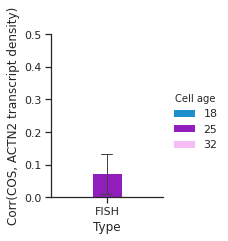

In [48]:
pack_complex_corr_col(
    actn2_df,
    "Combined organizational score",
    "ACTN2 (count/μm^2)",
    outcol="Corr(COS, ACTN2 transcript density)",
)

plt.figure(figsize=(2,3))
p_bar = sns.barplot(
    data=actn2_df.dropna(subset=["Combined organizational score", "ACTN2 (count/μm^2)"]),
    x="Type",
    y="Corr(COS, ACTN2 transcript density)",
    hue="Cell age",
    hue_order=[18, 25, 32],
    palette=DAY_COLOR_PALETTE_THREE,
    estimator=spearman_on_complex_col,
    n_boot=1000,
    ci=95,
    errwidth=1,
    capsize=0.1,
);
p_bar.set(ylim=(0, 0.5));


sns.despine();
plt.legend(title="Cell age", bbox_to_anchor=(1.0, 0.7), frameon=False);

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig5f_fish_cos_transcript_density_corr.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig5f_fish_cos_transcript_density_corr.svg', bbox_inches = "tight")

In [49]:
corr_boots = sns.algorithms.bootstrap(
            actn2_df.dropna(subset=["Combined organizational score", "ACTN2 (count/μm^2)"])["Corr(COS, ACTN2 transcript density)"],
            n_boot=1000,
            func=spearman_on_complex_col
        )

spearman_r = np.mean(corr_boots)
ci_interval = sns.utils.ci(corr_boots, which=95)
print(f"spearman R: {spearman_r} ci_lower: {ci_interval[0]}, ci_upper: {ci_interval[1]}")

spearman R: 0.07470635280820624 ci_lower: 0.01156396604752553, ci_upper: 0.13633818676018758


/home/tanyag/anaconda3/envs/cardio_fish_data/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


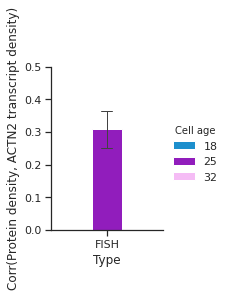

In [50]:
pack_complex_corr_col(
    actn2_df,
    "alpha-actinin protein intensity (density, background subtracted)",
    "ACTN2 (count/μm^2)",
    outcol="Corr(Protein density, ACTN2 transcript density)",
)

plt.figure(figsize=(2,3))
p_bar = sns.barplot(
    data=actn2_df.dropna(subset=["alpha-actinin protein intensity (density, background subtracted)", "ACTN2 (count/μm^2)"]),
    x="Type",
    y="Corr(Protein density, ACTN2 transcript density)",
    hue="Cell age",
    hue_order=[18, 25, 32],
    palette=DAY_COLOR_PALETTE_THREE,
    estimator=spearman_on_complex_col,
    n_boot=1000,
    ci=95,
    errwidth=1,
    capsize=0.1,
);
p_bar.set(ylim=(0, 0.5));


sns.despine();
plt.legend(title="Cell age", bbox_to_anchor=(1.0, 0.7), frameon=False);

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig5f_fish_protein_transcript_density_corr.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig5f_fish_protein_transcript_density_corr.svg', bbox_inches = "tight")

In [51]:
corr_boots = sns.algorithms.bootstrap(
            actn2_df.dropna(subset=["alpha-actinin protein intensity (density, background subtracted)", "ACTN2 (count/μm^2)"])["Corr(Protein density, ACTN2 transcript density)"],
            n_boot=1000,
            func=spearman_on_complex_col
        )

spearman_r = np.mean(corr_boots)
ci_interval = sns.utils.ci(corr_boots, which=95)
print(f"spearman R: {spearman_r} ci_lower: {ci_interval[0]}, ci_upper: {ci_interval[1]}")

spearman R: 0.3095863866126053 ci_lower: 0.2526929087531942, ci_upper: 0.3667634200000988


### Figure 6B cos vs transcript correlation bar plot

#### melt fish data for tidy plots

In [52]:
melt_feats = {
    "(count/μm^2)" : [c for c in df.columns if c.endswith("(count/μm^2)")]
}

melted_dfs = {
    feat:df[df.Type == 'FISH'].melt(
        id_vars=[c for c in df.columns if c not in cols],
        value_vars=cols,
        var_name="FISH probe",
        value_name=f"FISH probe {feat}",
    ).dropna(
        subset=[f"FISH probe {feat}"]
    ).reset_index(
        drop=True
    )
    for feat, cols in melt_feats.items()
}

for feat,v in melted_dfs.items():
    melted_dfs[feat]["FISH probe"] = melted_dfs[feat]["FISH probe"].str.split().str.get(0)

# TODO if counts make it back in will need to merge
df_fish_tidy = melted_dfs["(count/μm^2)"]

In [53]:
assert 2*len(df[df.Type == 'FISH']) == len(df_fish_tidy)

## Plot FISH vs cos

In [54]:
DAY_COLORS_3_PLUS_GREY = ["grey", DAY_18_COLOR, DAY_25_COLOR, DAY_32_COLOR]
DAY_COLOR_PALETTE_3_PLUS_GREY = sns.color_palette(DAY_COLORS_3_PLUS_GREY)

DAY_COLORS_2_PLUS_GREY = ["grey", DAY_18_COLOR, DAY_32_COLOR]
DAY_COLOR_PALETTE_2_PLUS_GREY = sns.color_palette(DAY_COLORS_2_PLUS_GREY)

### scatter plots

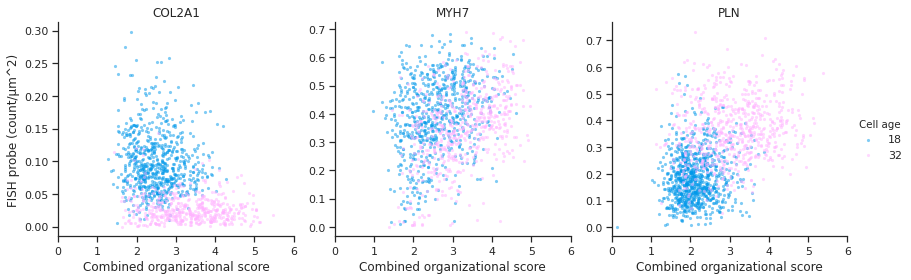

In [55]:
g = sns.FacetGrid(
    data=df_fish_tidy[df_fish_tidy["Cell age"].isin([18, 32])].sample(frac=1, replace=False).reset_index(drop=True),
    col="FISH probe",
    col_order=['COL2A1', 'MYH7', 'PLN'],
    col_wrap=3,
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    sharex=True,
    xlim=(0,6),
    sharey=False,
    height=4.0,
    aspect=1.0,
)

g = g.map(
    plt.scatter,
    "Combined organizational score",
    "FISH probe (count/μm^2)",
    s=10,
    alpha=0.5,
    linewidth=0,
).add_legend()

g.set_titles("{col_name}")

sns.despine()

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig6cde_probe_density_vs_org_score.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig6cde_probe_density_vs_org_score.svg', format="svg", bbox_inches = "tight")

### bar plots

/home/tanyag/anaconda3/envs/cardio_fish_data/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


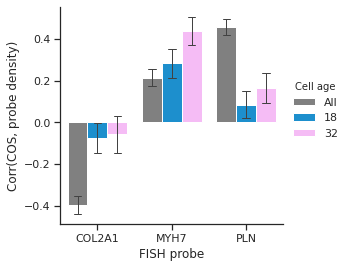

In [56]:
df_fish_tidy_dummy_all = df_fish_tidy.copy()
df_fish_tidy_dummy_all["Cell age"] = "All"
df_fish_tidy_dummy_all = df_fish_tidy_dummy_all.append(df_fish_tidy).reset_index(drop=True)

pack_complex_corr_col(
    df_fish_tidy_dummy_all,
    "Combined organizational score",
    "FISH probe (count/μm^2)",
    outcol="Corr(COS, probe density)",
)

plt.figure(figsize=(4, 4))
sns.barplot(
    data=df_fish_tidy_dummy_all[df_fish_tidy_dummy_all["Cell age"].isin(["All", 18, 32])].dropna(subset=["Combined organizational score", "FISH probe (count/μm^2)"]),
    x="FISH probe",
    y="Corr(COS, probe density)",
    order=['COL2A1', 'MYH7', 'PLN'],
    hue="Cell age",
    hue_order=["All", 18, 32],
    palette=DAY_COLOR_PALETTE_2_PLUS_GREY,
    estimator=spearman_on_complex_col,
    n_boot=1000,
    ci=95,
    errwidth=1,
    capsize=0.1,
    dodge=True,
);
sns.despine();
plt.legend(title="Cell age", bbox_to_anchor=(1.0, 0.7), frameon=False);

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig6b_probe_density_vs_org_score_by_day.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig6b_probe_density_vs_org_score_by_day.svg', format="svg", bbox_inches = "tight")

In [57]:
df_fish_tidy_dummy_all[df_fish_tidy_dummy_all["Cell age"].isin(["All", 18, 32])].groupby(["Cell age", "FISH probe"]).count()["Dataset"].to_csv("probe_cell_counts.csv", index=True)

### Spearman correlations and confidence intervals for Supplemenatry Table 3

In [58]:
x = "Combined organizational score"
y = "FISH probe (count/μm^2)"
col = "FISH probe"
hue = "Cell age"

df_corr_all = pd.DataFrame(columns = ["Dataset", col, hue, f"Spearman R ({x}, {y})"])

In [59]:
for probe in df_fish_tidy_dummy_all["FISH probe"].unique():
    for age in df_fish_tidy_dummy_all["Cell age"].unique():
        corr_boots = sns.algorithms.bootstrap(
            df_fish_tidy_dummy_all[(df_fish_tidy_dummy_all["FISH probe"] == probe) & (df_fish_tidy_dummy_all["Cell age"] == age)]["Corr(COS, probe density)"],
            n_boot=1000,
            func=spearman_on_complex_col
        )
        
        spearman_r = np.mean(corr_boots)
        ci_interval = sns.utils.ci(corr_boots, which=95)
        
        df_corr_all= df_corr_all.append(
                pd.DataFrame({
                    "Dataset": "FISH",
                    "FISH probe": [probe],
                    "Cell age": [age],
                    f"Spearman R ({x}, {y})": spearman_r,
                    "95 percent ci lower": ci_interval[0],
                    "95 percent ci upper": ci_interval[1]
                })
            )

In [ ]:
#df_corr_all.to_csv("gene_cos_transcript_spearmanr_20201207.csv", index=False)

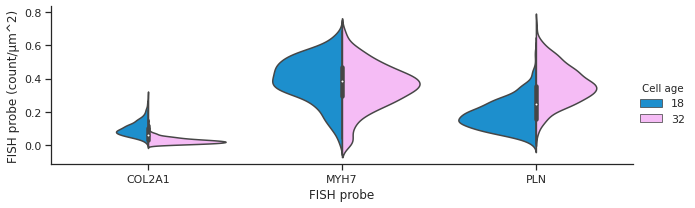

In [62]:
sns.catplot(
    kind="violin",
    split=True,
    data=df_fish_tidy[df_fish_tidy["Cell age"].isin([18, 32])],
    x="FISH probe",
    order=['COL2A1', 'MYH7', 'PLN'],
    y="FISH probe (count/μm^2)",
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    height=3,
    aspect=3
)
sns.despine()

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'fig6cde_probe_density_violins.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'fig6cde_probe_density_violins.svg', format="svg", bbox_inches = "tight")

## Supplamentary figures

### Supp Figure 2H Live heatmap of fraction area by class type

(7544, 68)
(6214, 68)
(4287, 68)


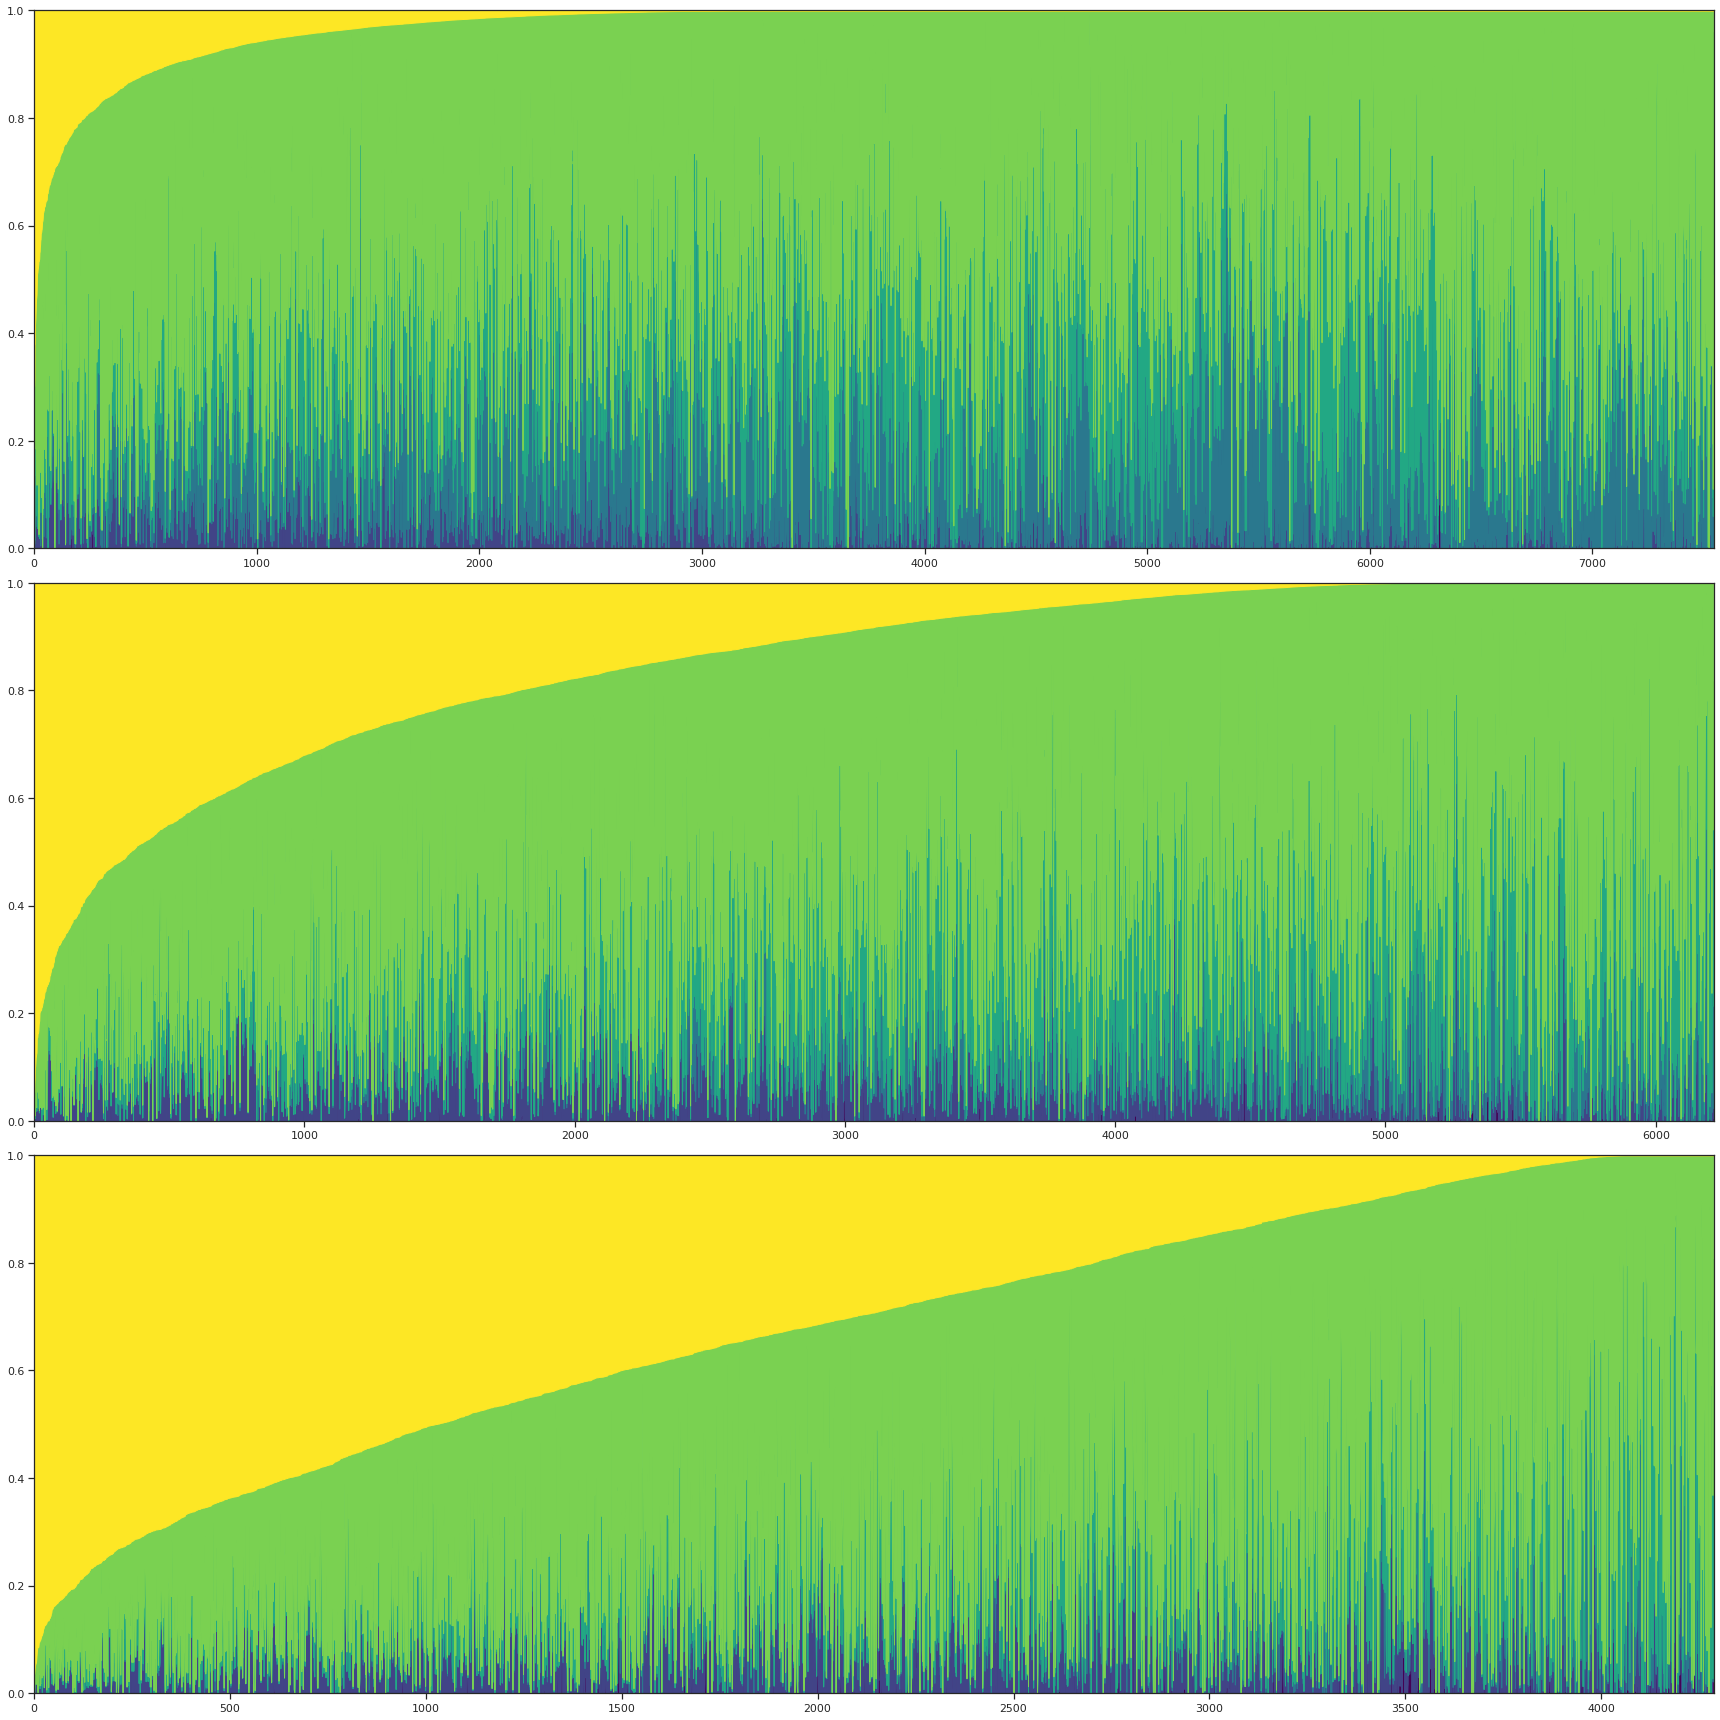

In [63]:
ranking_variable = 'Fraction cell area organized z-disks'
    
fig, ax = plt.subplots(3,1, figsize=(24,24))
for id_age, (age, df_age) in enumerate(df[df.Type=="Live"].groupby("Cell age")):
    df_age = df_age.sort_values(ranking_variable, ascending=False)
    print(df_age.shape)

    x = np.arange(df_age.shape[0])
    y = np.zeros(x.shape, dtype = np.float32)

    ax[id_age].set_ylim(0,1)
    ax[id_age].set_xlim(0,x.size)

    for id_yvar, yvar in enumerate(yvars_set1):
        y_sup = y + df_age[yvar].values
        ax[id_age].fill_between(x[:],y1=y,y2=y_sup, color=viridis(id_yvar/len(yvars_set1)))
        y = y_sup
        
plt.tight_layout()
if SAVE:
    plt.savefig(f'heatmap_rankby_{ranking_variable}.png')
    plt.savefig(save_dir_pngs/f'supp_fig2h_heatmap_rankby_{ranking_variable}.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/f'supp_fig2h_heatmap_rankby_{ranking_variable}.svg', format="svg", bbox_inches = "tight")
plt.show()

#### Live heatmaps Experiment 1 (replate 2019-05-17)

(2714, 68)
(2109, 68)


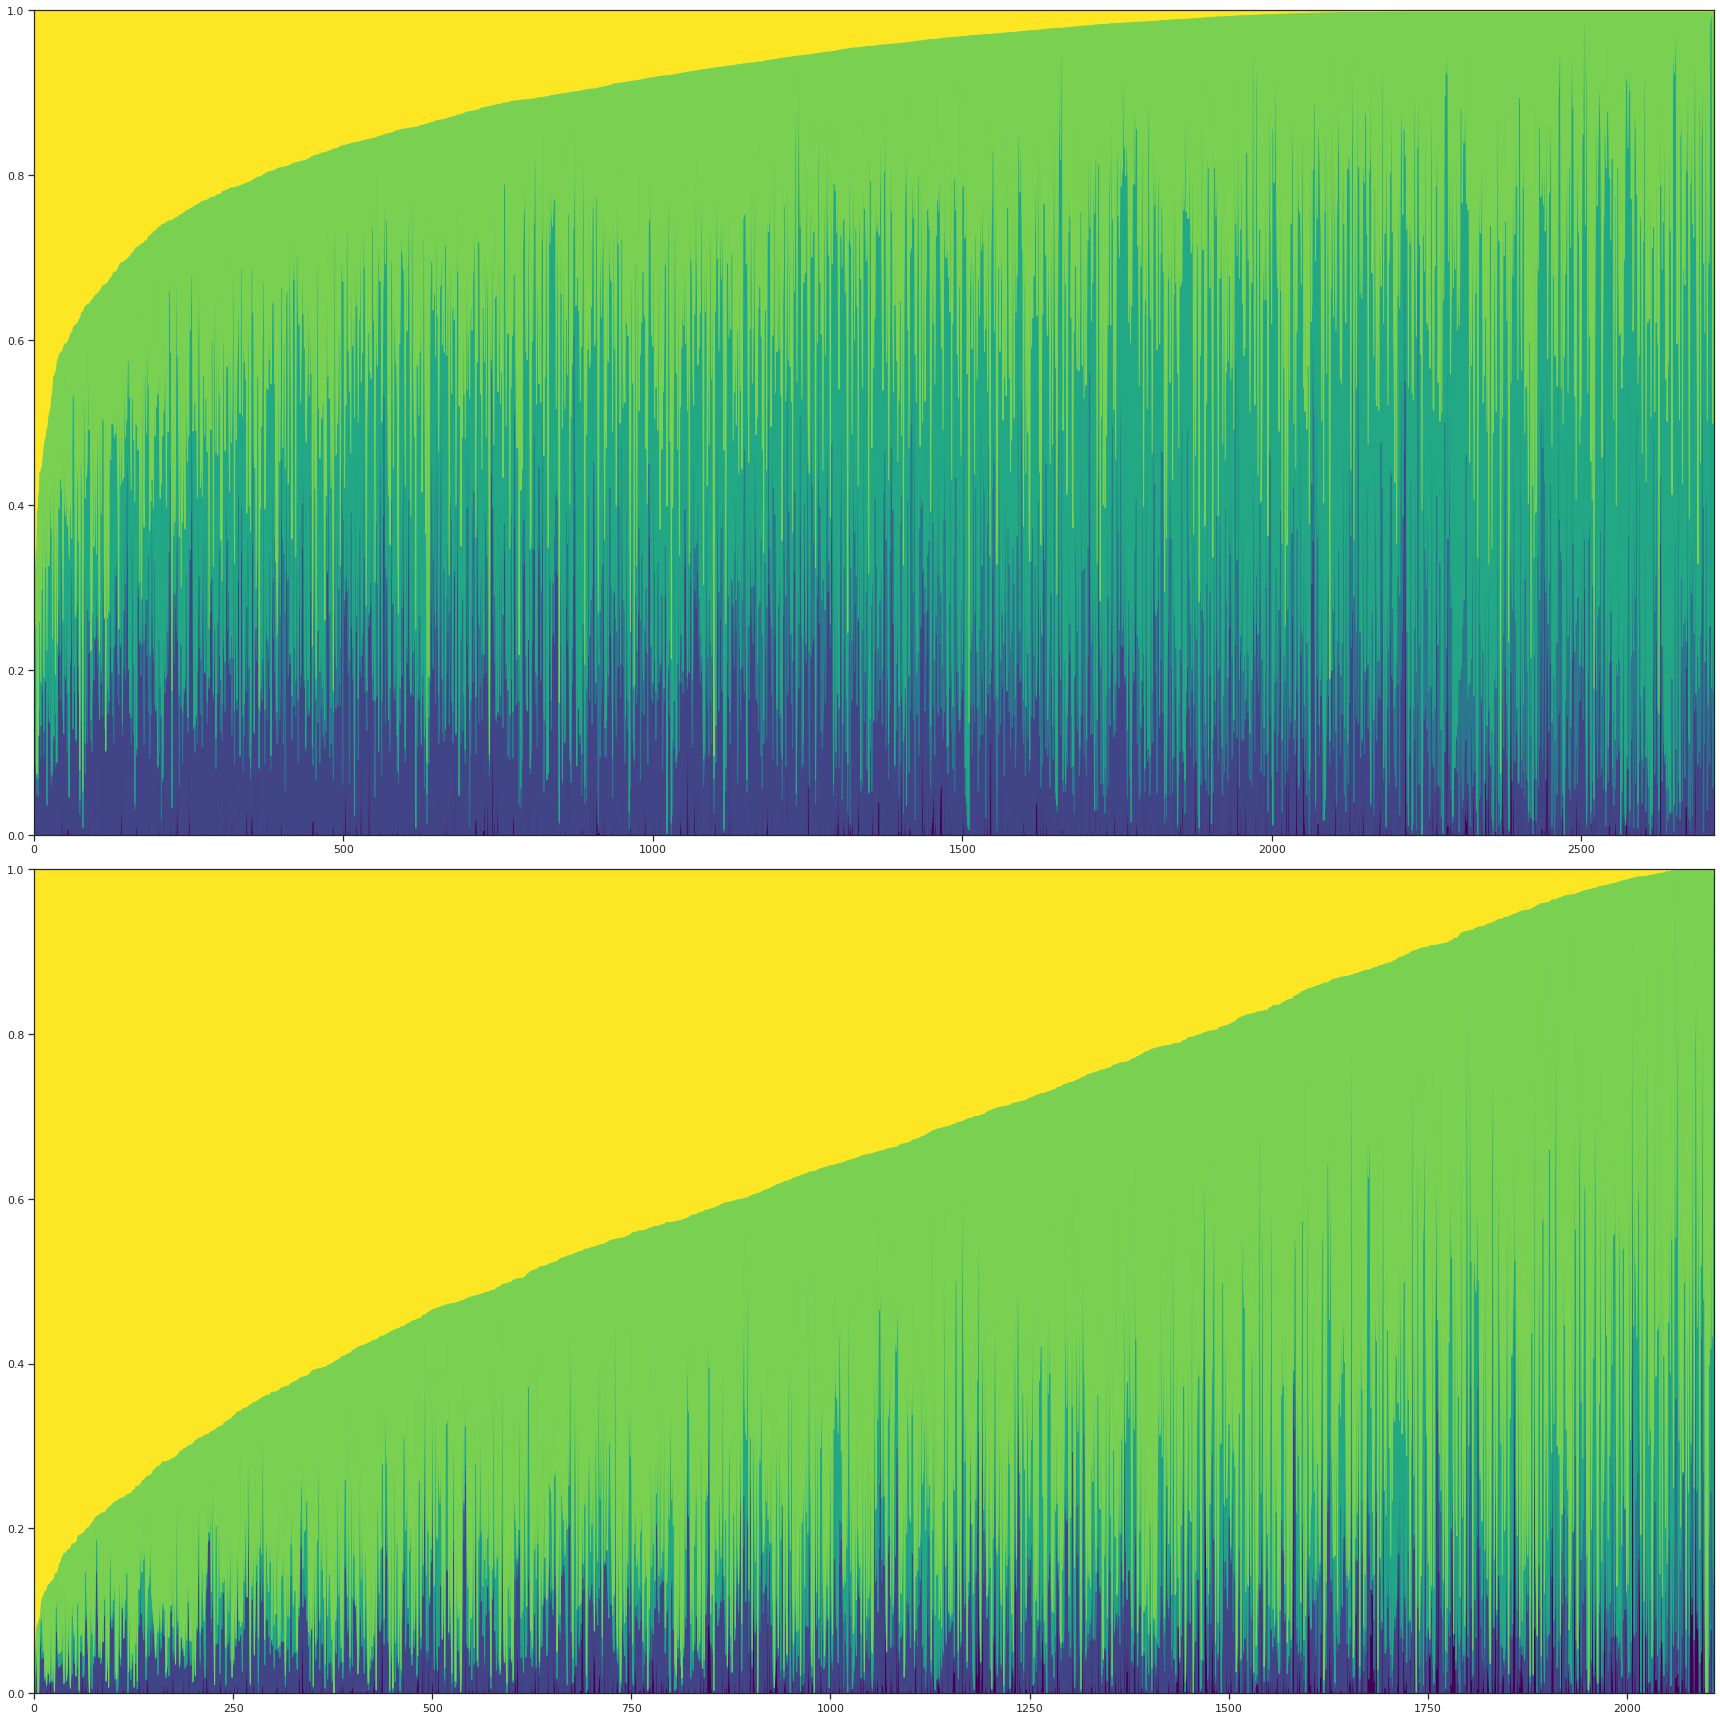

(3479, 68)
(2833, 68)


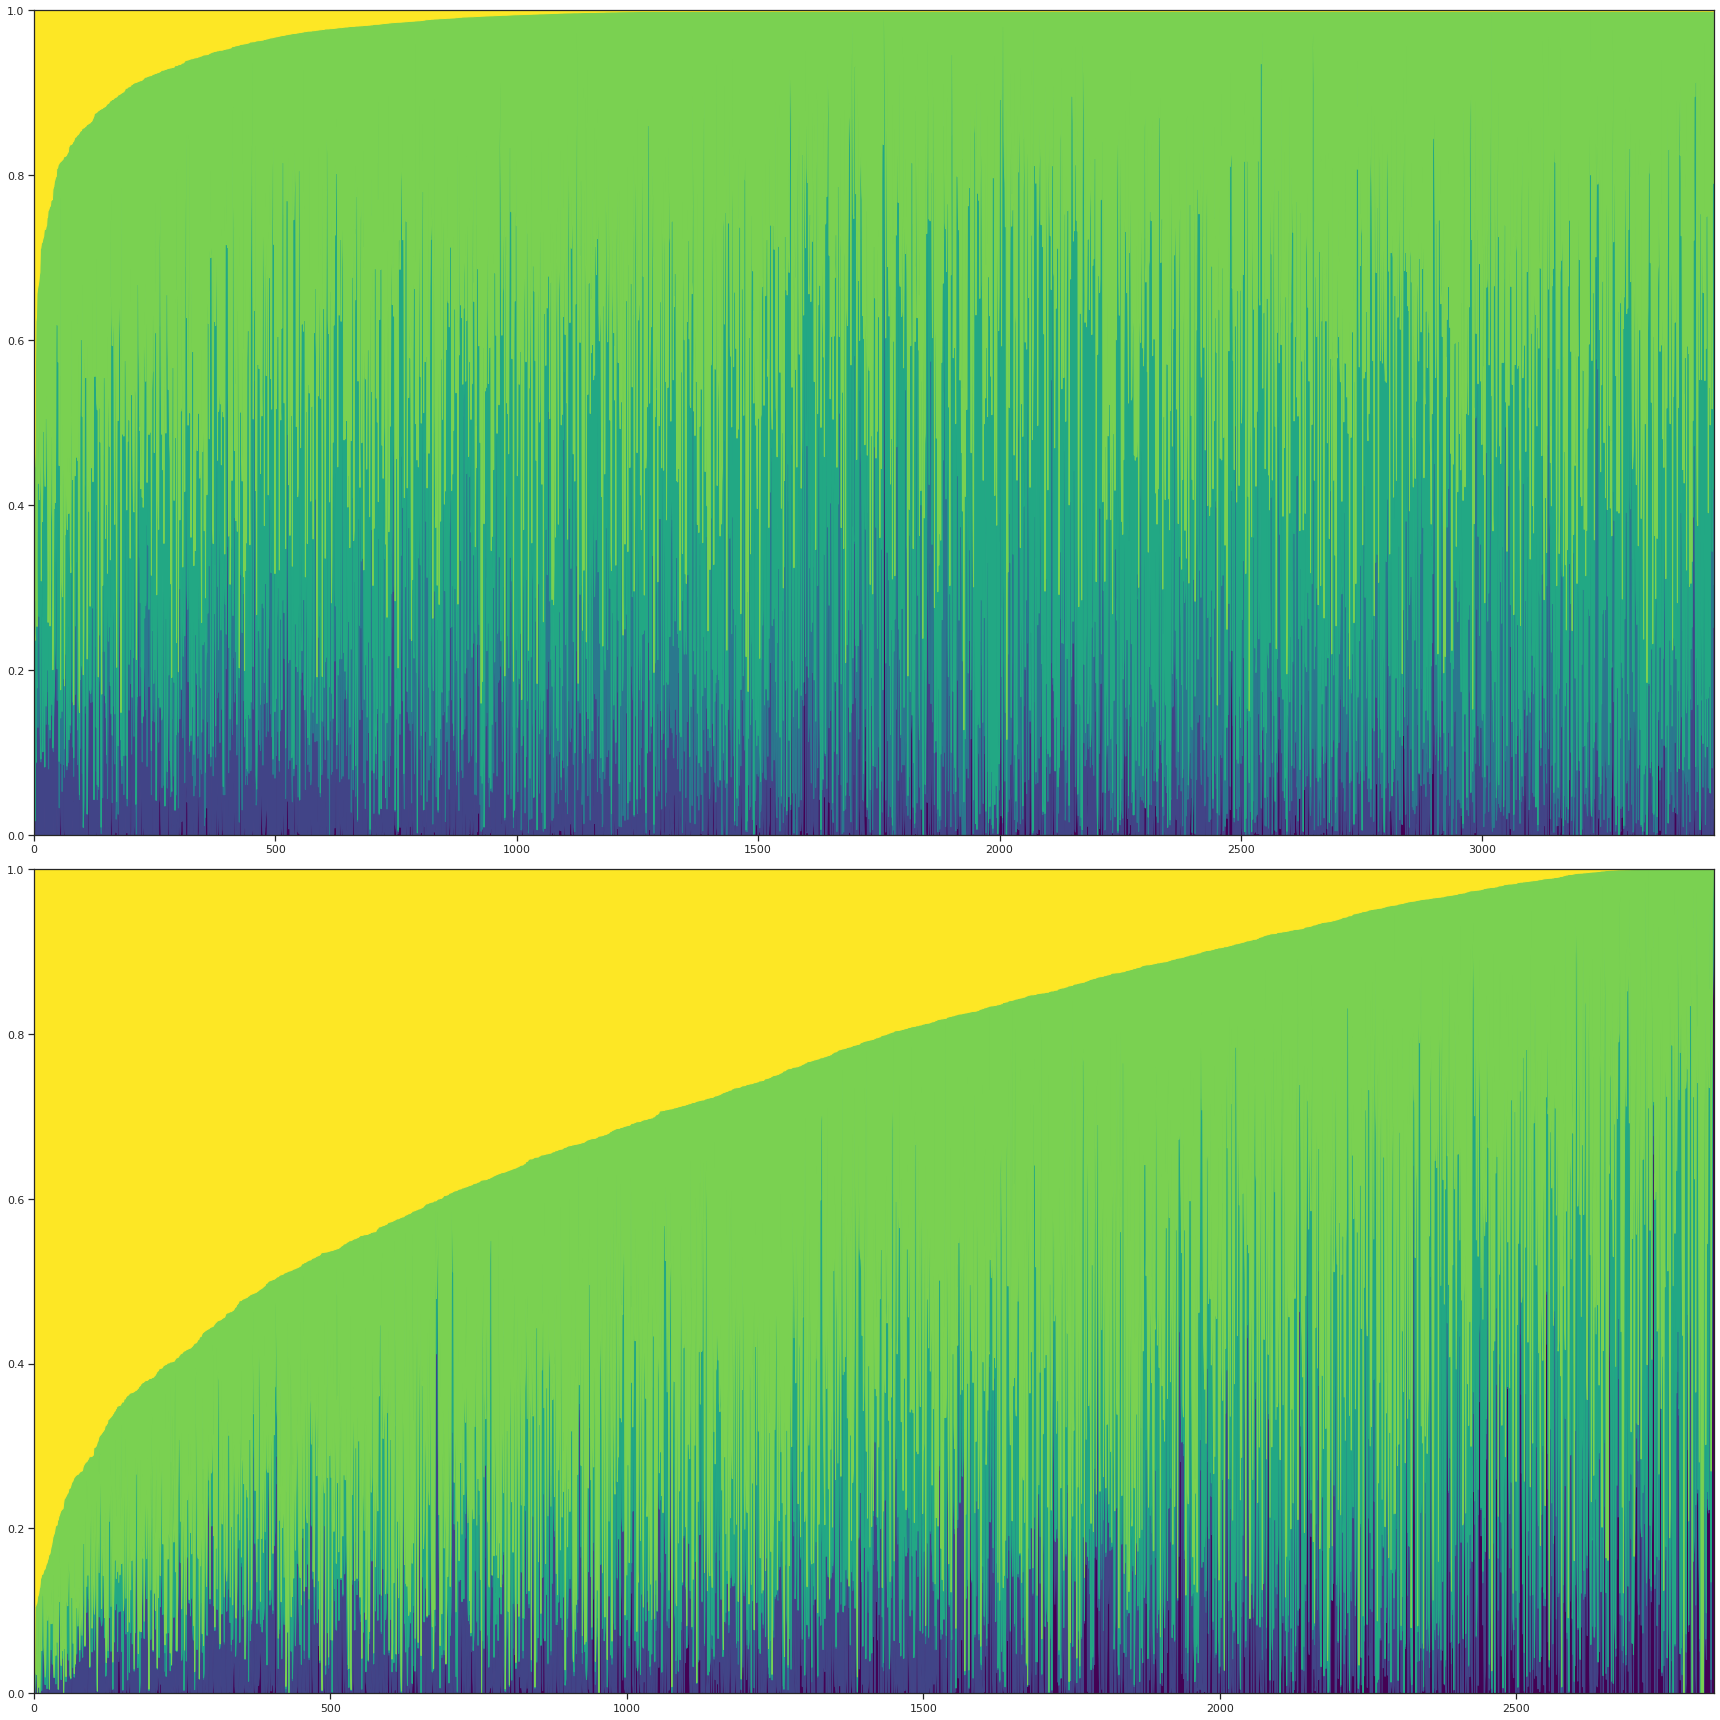

(1329, 68)
(974, 68)


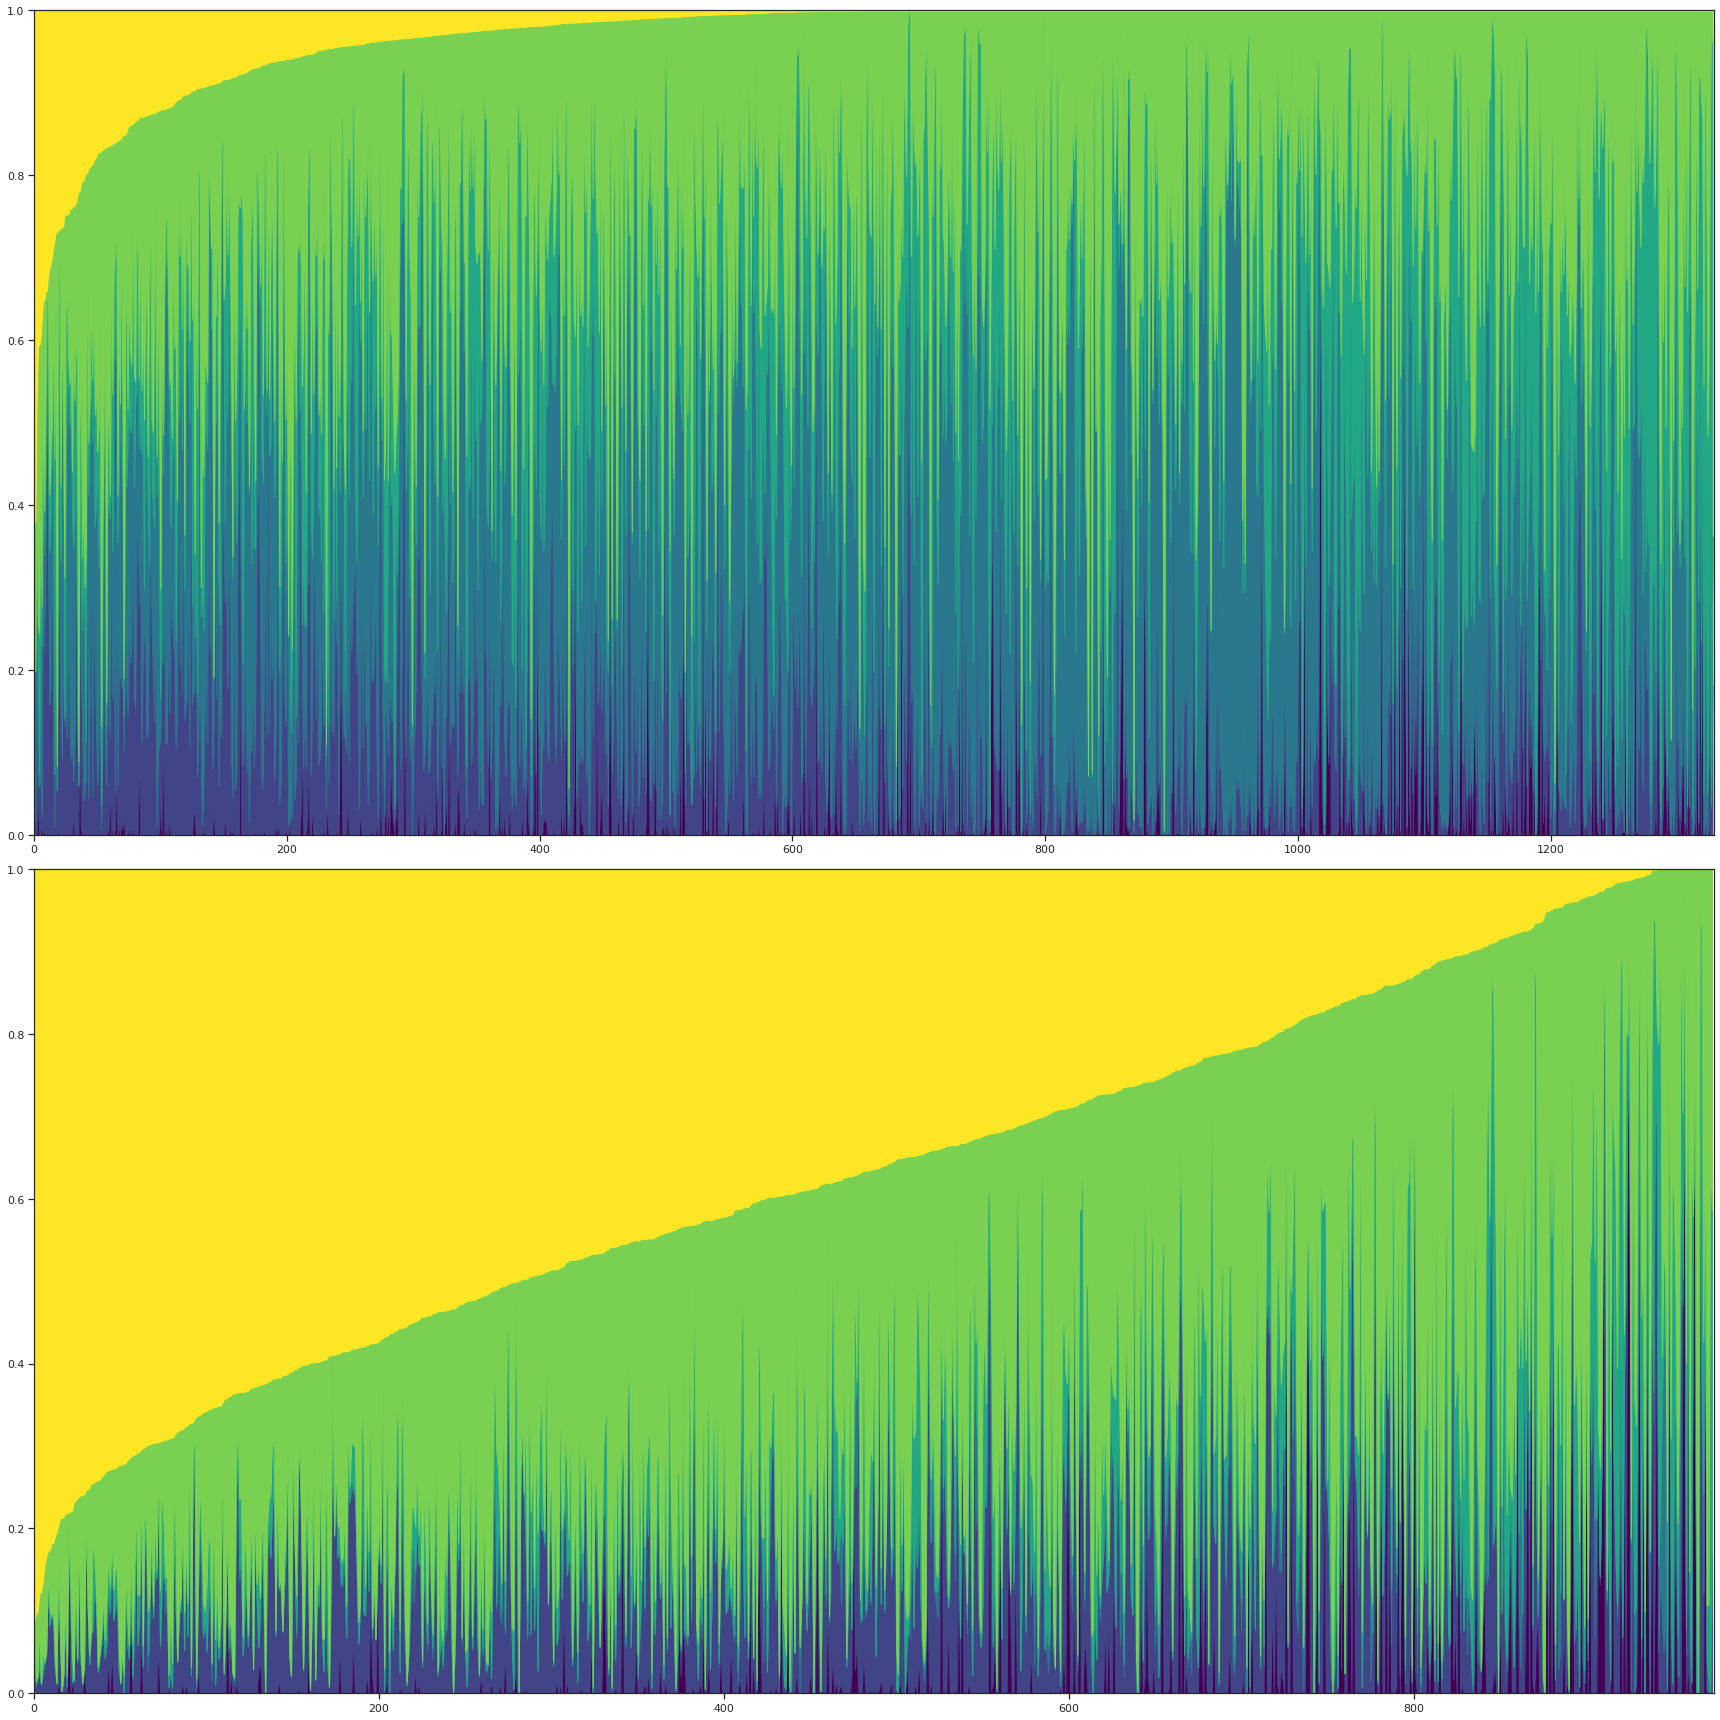

(2078, 68)
(1119, 68)


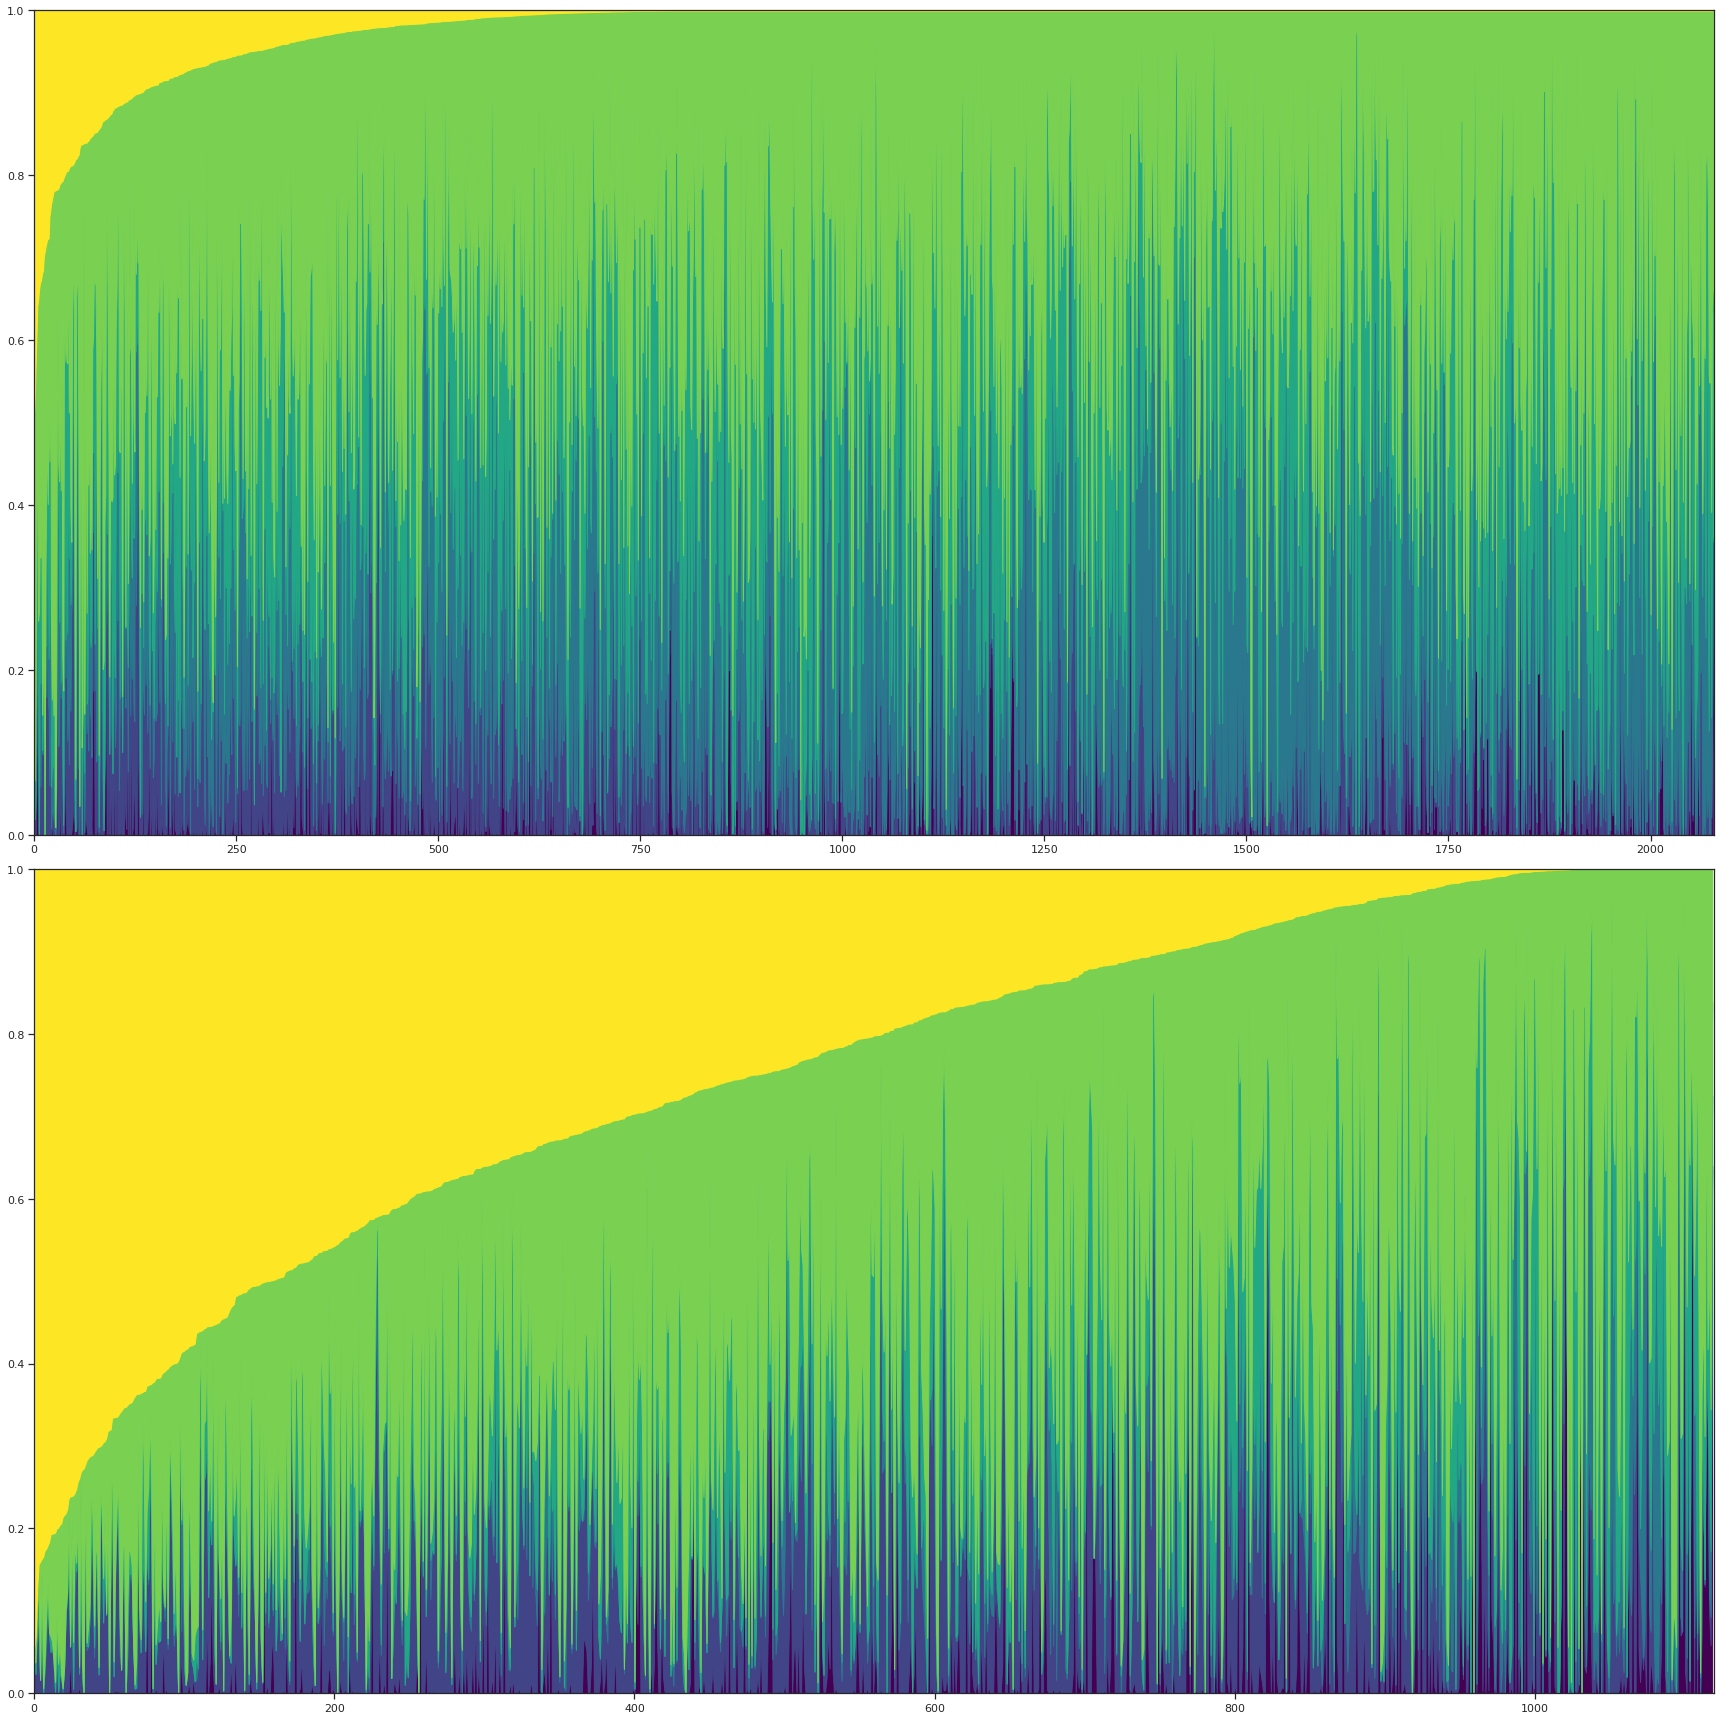

In [64]:
ranking_variable = 'Fraction cell area organized z-disks'
replates = {
    "exp1": "2019-05-17",
    "exp3": "2019-05-24"
}

for exp_type in df.Type.unique():
    for diff_exp in replates.keys():
        replate_date = replates[diff_exp]
        fig, ax = plt.subplots(2,1, figsize=(24,24))
        for id_age, (age, df_age) in enumerate(df[(df.Type==exp_type) & (df.replate_date==replate_date) & (df["Cell age"].isin([18, 32]))].groupby("Cell age")):
            df_age = df_age.sort_values(ranking_variable, ascending=False)
            print(df_age.shape)

            x = np.arange(df_age.shape[0])
            y = np.zeros(x.shape, dtype = np.float32)

            ax[id_age].set_ylim(0,1)
            ax[id_age].set_xlim(0,x.size)

            for id_yvar, yvar in enumerate(yvars_set1):
                y_sup = y + df_age[yvar].values
                ax[id_age].fill_between(x[:],y1=y,y2=y_sup, color=viridis(id_yvar/len(yvars_set1)))
                y = y_sup

        plt.tight_layout()
        if SAVE:
            plt.savefig(f'heatmap_rankby_{ranking_variable}.png')
            plt.savefig(save_dir_pngs/f'supp_fig2h_heatmap_rankby_{ranking_variable}_{exp_type}_{diff_exp}.png', dpi=300, bbox_inches = "tight")
            plt.savefig(save_dir_svgs/f'supp_fig2h_heatmap_rankby_{ranking_variable}_{exp_type}_{diff_exp}.svg', format="svg", bbox_inches = "tight")
        plt.show()

### Supp Figure 2I bar plot of expert scores

In [65]:
df_corrs_exp_both_cos["Expert-COS correlation (both)"]

0    0.673317
1    0.632085
2    0.665655
Name: Expert-COS correlation (both), dtype: float64

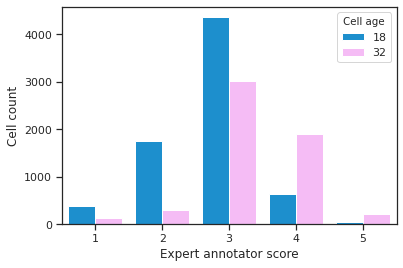

In [66]:
dims = (6, 4)
fig, ax = plt.subplots(figsize=dims)

score_count_plot = sns.countplot(
    x="Expert score",
    hue="Cell age",
    data=df_expert_melt[df_expert_melt["Cell age"].isin([18, 32])],
    palette=DAY_COLOR_PALETTE
)
score_count_plot.set(
    xlabel='Expert annotator score',
    ylabel='Cell count',
)

score_count_plot.set_xticklabels([1,2,3,4,5])
#score_count_plot.set_yticklabels([1,2,3,4,5]);

if SAVE:
    plt.savefig(save_dir_pngs/f"supp_fig2i_expert_by_day18_32.png", dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/f"supp_fig2i_expert_by_day18_32.svg", format="svg", bbox_inches = "tight")

### Supp Figure 2J Expert vs. Expert confusion matrix

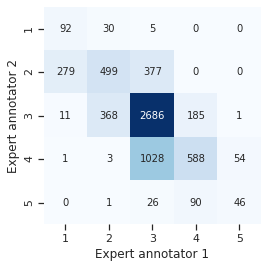

In [68]:
conf_mat = confusion_matrix(
        df_expert[df_expert["Cell age"].isin([18, 32])]["kg_structure_org_score"],
        df_expert[df_expert["Cell age"].isin([18, 32])]["mh_structure_org_score"]
    )

    #data_colors = {"OldFish": "Blues", "NewFish": "Reds", "Live": "Greens"}
    
dims = (4, 4)
fig, ax = plt.subplots(figsize=dims)
conf_mat_plot = sns.heatmap(
    conf_mat,
    annot=True,
    fmt="d",
    square=True,
    cmap="Blues",
    cbar=False,
)

conf_mat_plot.set(
    xlabel='Expert annotator 1',
    ylabel='Expert annotator 2',
)
conf_mat_plot.set_xticklabels([1,2,3,4,5])
conf_mat_plot.set_yticklabels([1,2,3,4,5]);

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/f"supp_fig2j_expert_expert_COS_conf_mat.png", dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/f"supp_fig2j_expert_expert_COS_conf_mat.svg", format="svg", bbox_inches = "tight")

### Supp Figure 3B MCV, peak height and peak distance in expert scored cells by age

In [69]:
g = sns.pairplot(
    df_expert.sample(frac=1, replace=False).reset_index(drop=True),
    x_vars=['Max coefficient var', 'Peak height', 'Peak distance (μm)'],
    y_vars=['Max coefficient var', 'Peak height', 'Peak distance (μm)'],
    hue='Cell age',
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    plot_kws=dict(
        linewidth=0,
        alpha = 0.25,
        s=20
    ),
    diag_kws=dict(
        bw=0.1
    )
);

mcv_lims = (0,1)
ph_lims = (0.15,0.85)
pd_lims = (0.5,3.0)

g.axes[0,0].set_xlim(mcv_lims)
g.axes[1,1].set_xlim(ph_lims)
g.axes[2,2].set_xlim(pd_lims)

g.axes[0,1].set_xlim(ph_lims)
g.axes[0,1].set_ylim(mcv_lims)
g.axes[1,0].set_xlim(mcv_lims)
g.axes[1,0].set_ylim(ph_lims)

g.axes[0,2].set_xlim(pd_lims)
g.axes[0,2].set_ylim(mcv_lims)
g.axes[2,0].set_xlim(mcv_lims)
g.axes[2,0].set_ylim(pd_lims)

g.axes[1,2].set_xlim(pd_lims)
g.axes[1,2].set_ylim(ph_lims)
g.axes[2,1].set_xlim(ph_lims)
g.axes[2,1].set_ylim(pd_lims);

plt.subplots_adjust(hspace=0.2, wspace=0.2)
g._legend.set_bbox_to_anchor((1.05, 0.5))

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/f'supp_fig3b_global_alignment_correlations_day.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/f'supp_fig3b_global_alignment_correlations_day.svg', format="svg", bbox_inches = "tight")

### Supp Figure 3B MCV, peak height and peak distance in expert scored cells by expert score

In [70]:
g = sns.pairplot(
    df_expert[df_expert["Cell age"].isin([18, 32])].sample(frac=1, replace=False).reset_index(drop=True),
    x_vars=['Max coefficient var', 'Peak height', 'Peak distance (μm)'],
    y_vars=['Max coefficient var', 'Peak height', 'Peak distance (μm)'],
    hue="Expert structural annotation score (grouped)",
    hue_order=["1-2", "3", "4-5"],
    aspect=1,
    plot_kws=dict(
        linewidth=0,
        alpha = 0.25,
        s=20
    ),
    diag_kws=dict(
        bw=0.1
    )
);

mcv_lims = (0,1)
ph_lims = (0.15,0.85)
pd_lims = (0.5,3.0)

g.axes[0,0].set_xlim(mcv_lims)
g.axes[1,1].set_xlim(ph_lims)
g.axes[2,2].set_xlim(pd_lims)

g.axes[0,1].set_xlim(ph_lims)
g.axes[0,1].set_ylim(mcv_lims)
g.axes[1,0].set_xlim(mcv_lims)
g.axes[1,0].set_ylim(ph_lims)

g.axes[0,2].set_xlim(pd_lims)
g.axes[0,2].set_ylim(mcv_lims)
g.axes[2,0].set_xlim(mcv_lims)
g.axes[2,0].set_ylim(pd_lims)

g.axes[1,2].set_xlim(pd_lims)
g.axes[1,2].set_ylim(ph_lims)
g.axes[2,1].set_xlim(ph_lims)
g.axes[2,1].set_ylim(pd_lims);

plt.subplots_adjust(hspace=0.2, wspace=0.2)
g._legend.set_bbox_to_anchor((0.8, 0.5))
g._legend.set_title("Expert score")

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/f'supp_fig3b_global_alignment_correlations_score.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/f'supp_fig3b_global_alignment_correlations_score.svg', format="svg", bbox_inches = "tight")

### Supp. 4A COS dist. in expert scored cells by dataset (training, bonus test, live test)

In [71]:
bins = np.linspace(0,6,31)

g = sns.FacetGrid(
    df_expert,
    hue='Expert structural annotation score (grouped)',
    hue_order=["1-2", "3", "4-5"],
    col="Dataset",
    height=4
)
g = g.map(
    sns.distplot,
    'Combined organizational score',
    bins=bins
).add_legend()

g.set(xlim=(0, 6));
g._legend.set(bbox_to_anchor=(0.75, 0.6))
g._legend.set_title("Expert score  ")
g.set(ylabel='Probability density');

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'supp_fig4a_linear_model_distplot_grouped_by_human_score.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'supp_fig4a_linear_model_distplot_grouped_by_human_score.svg', format="svg", bbox_inches = "tight")

### Supp Figure 4B Cell features, local, and global alignment distributions for all expert scored cells

In [72]:
lim_map={
    'Cell area (μm^2)': (0.0, 10_000),
     'Cell aspect ratio': (0.0, 1.0),
     'Fraction cell area background': (0.0, 1.0),
     'Fraction cell area diffuse/other': (0.0, 1.0),
     'Fraction cell area fibers': (0.0, 1.0),
     'Fraction cell area disorganized puncta': (0.0, 1.0),
     'Fraction cell area organized puncta': (0.0, 1.0),
     'Fraction cell area organized z-disks': (0.0, 1.0),
     'Max coefficient var': (0.0, 1.0),
     'Peak height': (0.0, 1.0),
     'Peak distance (μm)': (0.5, 3.0),
}

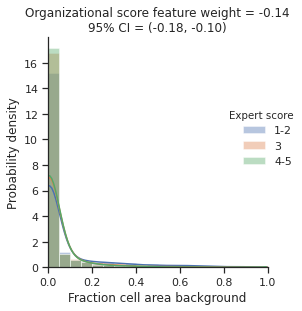

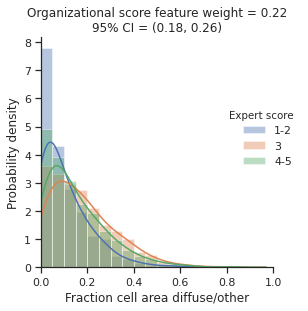

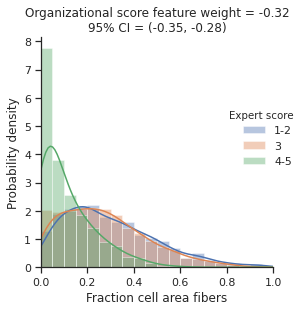

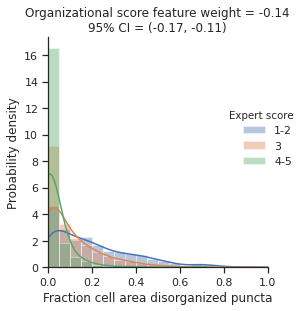

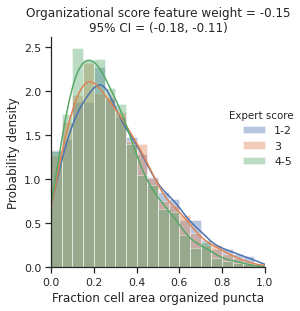

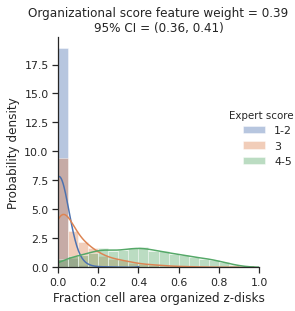

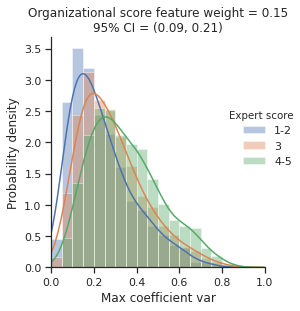

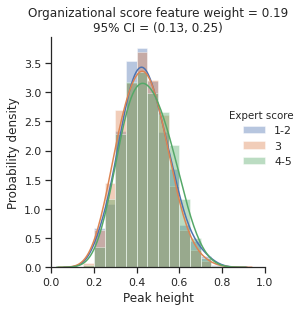

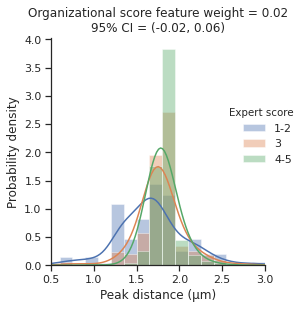

In [73]:
for feature in BAR_PLOT_COLUMNS:

    bins = np.linspace(0,lim_map[feature][1],21)

    g = sns.FacetGrid(
        df_expert,
        hue='Expert structural annotation score (grouped)',
        hue_order=["1-2", "3", "4-5"],
        height=4
    );
    g = g.map(
        sns.distplot,
        feature,
        bins=bins,
        kde_kws=dict(bw=bins[-1]/len(bins))
    ).add_legend();

    row = reg_plot_ci_df[reg_plot_ci_df["Feature"]==feature].iloc[0,:]
    title = f'Organizational score feature weight = {row["Feature weight (mean)"]:.2f}\n95% CI = ({row["Feature weight (CI low)"]:.2f}, {row["Feature weight (CI high)"]:.2f})'
    
    g.set(
        xlim=lim_map[feature],
        xlabel=feature.replace("_", " ").capitalize(),
        ylabel='Probability density',
        title=title
    );
    g._legend.set(bbox_to_anchor=(0.6, 0.6))
    g._legend.set_title("Expert score    ")

    # save png and svg
    if SAVE:
        plt.savefig(save_dir_pngs/f'supp_fig4B_{safe(feature)}_distplot_grouped_by_human_score.png', dpi=300, bbox_inches = "tight");
        plt.savefig(save_dir_svgs/f'supp_fig4B_{safe(feature)}_distplot_grouped_by_human_score.svg', format="svg", bbox_inches = "tight");

### Supp Figure 4C All expert score vs COS

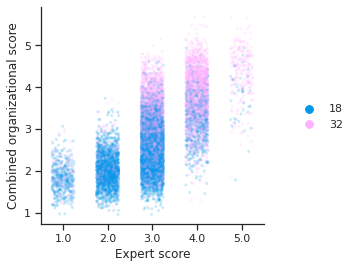

In [74]:
dims = (4, 4)
fig, ax = plt.subplots(figsize=dims)

g = sns.stripplot(
    data=df_expert_melt.sample(frac=1, replace=False).reset_index(drop=True),
    x="Expert score",
    y="Combined organizational score",
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    alpha=0.2,
    linewidth=0,
    jitter=0.25,
    s=3
)

sns.despine()
plt.legend(bbox_to_anchor=(1.4, 0.6),frameon=False)

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'supp_fig4c_linear_model_pred_vs_true.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'supp_fig4c_linear_model_pred_vs_true.svg', format="svg", bbox_inches = "tight")

### Supp Figure 4D COS violins by plate color coded by replate date

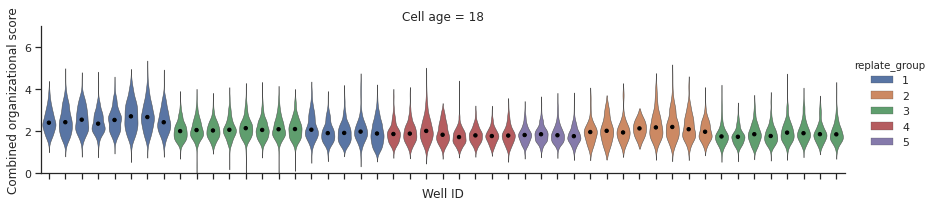

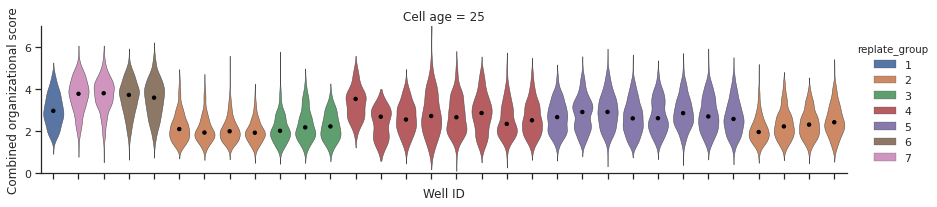

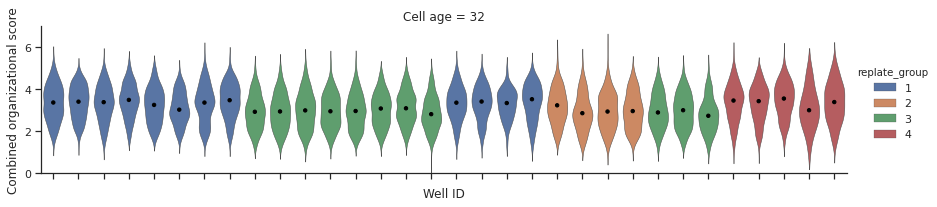

In [75]:
feature='Combined organizational score'

for a in [18, 25, 32]:
    g = sns.catplot(
        data=df[df["Cell age"].isin([a])].rename(columns={"ge_wellID":"Well ID"}),
        kind="violin",
        height=3,
        aspect=4,
        dodge=False,
        sharex=False,
        sharey=False,
        inner=None,
        linewidth=0.5,
        row="Cell age",
        #col="Dataset",
        x="Well ID",
        y=feature,
        hue="replate_group",
    )

    for i, age in enumerate(sorted(df[df["Cell age"].isin([a])]["Cell age"].unique())):
        sns.pointplot(
            ax=g.axes[i,0],
            data=df[df["Cell age"]==age].rename(columns={"ge_wellID":"Well ID"}),
            x="Well ID",
            y=feature,
            color='black',
            scale=0.5,
            estimator=np.median,
            ci=None,
            join=False,
        )

    g.set(xticklabels=[])
    plt.subplots_adjust(top=0.9)
    g.set(ylim=(0, 7));
    #g.fig.suptitle('COS distribution across Datasets', x="0.5");

    # save png and svg
    if SAVE:
        plt.savefig(save_dir_pngs/f'supp_fig4D_COS_dist_well_age_D{a}_ylim.png', dpi=300, bbox_inches = "tight")
        plt.savefig(save_dir_svgs/f'supp_fig4D_COS_dist_well_age_D{a}_ylim.svg', format="svg", bbox_inches = "tight")

Save another version by dataset

In [76]:
feature='Combined organizational score'

for a in [18, 25, 32]:
    g = sns.catplot(
        data=df[df["Cell age"].isin([a])].rename(columns={"ge_wellID":"Well ID"}),
        kind="violin",
        height=3,
        aspect=4,
        dodge=False,
        sharex=False,
        sharey=False,
        inner=None,
        linewidth=0.5,
        row="Cell age",
        #col="Dataset",
        x="Well ID",
        y=feature,
        hue="Dataset",
    )

    for i, age in enumerate(sorted(df[df["Cell age"].isin([a])]["Cell age"].unique())):
        sns.pointplot(
            ax=g.axes[i,0],
            data=df[df["Cell age"]==age].rename(columns={"ge_wellID":"Well ID"}),
            x="Well ID",
            y=feature,
            color='black',
            scale=0.5,
            estimator=np.median,
            ci=None,
            join=False,
        )

    g.set(xticklabels=[])
    plt.subplots_adjust(top=0.9)
    g.set(ylim=(0, 7));
    #g.fig.suptitle('COS distribution across Datasets', x="0.5");

    # save png and svg
    if SAVE:
        plt.savefig(save_dir_pngs/f'supp_fig4D_COS_dist_well_age_dataset_D{a}_ylim.png', dpi=300, bbox_inches = "tight")
        plt.savefig(save_dir_svgs/f'supp_fig4D_COS_dist_well_age_dataset_D{a}_ylim.svg', format="svg", bbox_inches = "tight")

### Figure S5A ACTN2 transcript wells raw transcript count vs. cell area

In [77]:
actn2_df[actn2_df.Type=="FISH"].dropna(subset=["ACTN2_count"]).sample(frac=1, replace=False).reset_index(drop=True)[["Cell area (μm^2)", "ACTN2_count"]].corr(method="spearman")

Cell area (μm^2)  ACTN2_count
Cell area (μm^2)          1.000000     0.759176
ACTN2_count               0.759176     1.000000

In [78]:
g = sns.FacetGrid(
    actn2_df[actn2_df.Type=="FISH"].dropna(subset=["ACTN2_count"]).sample(frac=1, replace=False).reset_index(drop=True),
    col="Type",
    col_wrap=3,
    sharex=True,
    #xlim=(0,6),
    sharey=True,
    height=4.0,
    aspect=1.0,
)
g.map(
    sns.scatterplot,
    "Cell area (μm^2)",
    "ACTN2_count",
    s=10,
    alpha=0.5,
    linewidth=0,
    color=DAY_25_COLOR
);

g.set_axis_labels(y_var="ACTN2 count")

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'supp_fig5a_actn2_transcript_count_cellarea.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'supp_fig5a_actn2_transcript_count_cellarea.svg', format="svg", bbox_inches = "tight")

In [79]:
pack_complex_corr_col(
    actn2_df,
    "ACTN2_count",
    "Cell area (μm^2)",
    outcol="Corr(Cell area (μm^2), ACTN2 transcript count)",
)
corr_boots = sns.algorithms.bootstrap(
            actn2_df[actn2_df.Type=="FISH"].dropna(subset=["ACTN2_count"]).sample(frac=1, replace=False).reset_index(drop=True)["Corr(Cell area (μm^2), ACTN2 transcript count)"],
            n_boot=1000,
            func=spearman_on_complex_col
        )

spearman_r = np.mean(corr_boots)
ci_interval = sns.utils.ci(corr_boots, which=95)
print(f"spearman R: {spearman_r} ci_lower: {ci_interval[0]}, ci_upper: {ci_interval[1]}")

spearman R: 0.7585677647787273 ci_lower: 0.726513893586314, ci_upper: 0.7876490740696221


In [80]:
pack_complex_corr_col(
    actn2_df,
    "ACTN2_count",
    "Cell area (μm^2)",
    outcol="Corr(Cell area (μm^2), ACTN2 transcript count)",
)
corr_boots = sns.algorithms.bootstrap(
            actn2_df[actn2_df.Type=="FISH"].dropna(subset=["ACTN2_count"]).sample(frac=1, replace=False).reset_index(drop=True)["Corr(Cell area (μm^2), ACTN2 transcript count)"],
            n_boot=1000,
            func=spearman_on_complex_col
        )

spearman_r = np.mean(corr_boots)
ci_interval = sns.utils.ci(corr_boots, which=95)
print(f"spearman R: {spearman_r} ci_lower: {ci_interval[0]}, ci_upper: {ci_interval[1]}")

spearman R: 0.7594608583210579 ci_lower: 0.727440272005282, ci_upper: 0.7864348763074686


### Get range of correlations for counts vs. Cell area

In [81]:
probes = ['ACTN2', 'COL2A1', 'MYH7', 'PLN', 'H19', 'MYH6', 'MYL7', 'TCAP', 'BAG3', 'MEF2C', 'NKX2', 'ATP2A2', 'BMPER', 'CNTN5', 'PRSS35', 'VCAN', 'HPRT1']

In [82]:
all_gene_cor_area_transcript = pd.DataFrame()
for gene in probes:
    c = f"{gene}_count"
    c_corr = f"Corr(Cell area (μm^2), {gene} transcript count)"
    #print(c)
    pack_complex_corr_col(
        df,
        c,
        "Cell area (μm^2)",
        outcol=c_corr,
    )
    corr_boots = sns.algorithms.bootstrap(
                df[df.Type=="FISH"].dropna(subset=[c]).reset_index(drop=True)[c_corr],
                n_boot=1000,
                func=spearman_on_complex_col
            )

    spearman_r = np.mean(corr_boots)
    ci_interval = sns.utils.ci(corr_boots, which=95)
    
    current_df = pd.DataFrame({"gene": [gene], "spearmanr": [spearman_r], "ci_lower": ci_interval[0], "ci_upper": ci_interval[1]})
    all_gene_cor_area_transcript = pd.concat([all_gene_cor_area_transcript, current_df])
    
    print(f"{gene} spearman R: {spearman_r} ci_lower: {ci_interval[0]}, ci_upper: {ci_interval[1]}")

ACTN2 spearman R: 0.7586686448988891 ci_lower: 0.7268822625522867, ci_upper: 0.7890409083817236
COL2A1 spearman R: 0.1907696029198707 ci_lower: 0.1322057585322027, ci_upper: 0.24537622749294585
MYH7 spearman R: 0.6926644493493078 ci_lower: 0.6606772806433528, ci_upper: 0.7231918656132493
PLN spearman R: 0.6253025042684558 ci_lower: 0.5917176850805174, ci_upper: 0.6572739936688802
H19 spearman R: 0.5631590013583645 ci_lower: 0.5229742234998929, ci_upper: 0.6026354320495056
MYH6 spearman R: 0.2232211066759823 ci_lower: 0.1842808459832689, ci_upper: 0.2638861434133602
MYL7 spearman R: 0.8794043764714584 ci_lower: 0.8627863313736854, ci_upper: 0.8952168816444506
TCAP spearman R: 0.49277779836255003 ci_lower: 0.4498020486382294, ci_upper: 0.5340485095188865
BAG3 spearman R: 0.6267338272983924 ci_lower: 0.58886487651603, ci_upper: 0.6660990126233973
MEF2C spearman R: 0.6080722694372489 ci_lower: 0.5733288099022702, ci_upper: 0.640146503714904
NKX2 spearman R: 0.5386273791449216 ci_lower: 0.5

In [ ]:
# all_gene_cor_area_transcript.to_csv("gene_transcript_count_v_cell_area.csv", index=False)

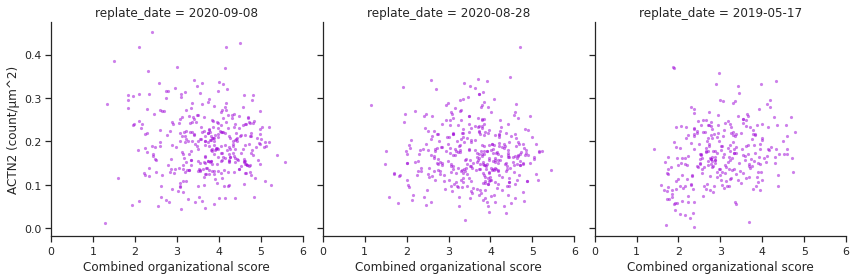

In [83]:
g = sns.FacetGrid(
    actn2_df[actn2_df.Type=="FISH"].dropna(subset=["ACTN2 (count/μm^2)"]).sample(frac=1, replace=False).reset_index(drop=True),
    col="replate_date",
    col_wrap=3,
    hue_order=["2019-05-17", "2020-08-28", "2020-09-08"],
    sharex=True,
    xlim=(0,6),
    sharey=True,
    height=4.0,
    aspect=1.0,
)
g.map(
    sns.scatterplot,
    "Combined organizational score",
    "ACTN2 (count/μm^2)",
    s=10,
    alpha=0.5,
    linewidth=0,
    color=DAY_25_COLOR
);

g.set_axis_labels(y_var="ACTN2 (count/μm^2)")

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'supp_fig5b_actn2_transcript_density_COS.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'supp_fig5b_actn2_transcript_density_COS.svg', format="svg", bbox_inches = "tight")

/home/tanyag/anaconda3/envs/cardio_fish_data/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


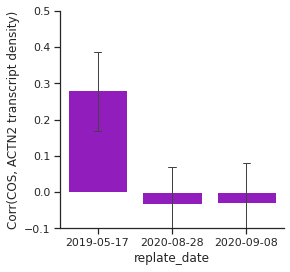

In [84]:
#plt.figure(figsize=(2,3))

dims = (4, 4)
fig, ax = plt.subplots(figsize=dims)


p_bar = sns.barplot(
    data=actn2_df.dropna(subset=["Combined organizational score", "ACTN2 (count/μm^2)"]),
    x="replate_date",
    y="Corr(COS, ACTN2 transcript density)",
    color=DAY_25_COLOR,
    estimator=spearman_on_complex_col,
    n_boot=1000,
    ci=95,
    errwidth=1,
    capsize=0.1,
    order=["2019-05-17", "2020-08-28", "2020-09-08"]
);
p_bar.set(ylim=(-0.1, 0.5));


sns.despine();
#plt.xticks(rotation=45)
# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'supp_fig5c_fish_cos_transcript_density_corr.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'supp_fig5c_fish_cos_transcript_density_corr.svg', bbox_inches = "tight")

In [85]:
for rp in actn2_df.replate_date.unique():
    corr_boots = sns.algorithms.bootstrap(
                actn2_df[actn2_df.replate_date==rp].dropna(subset=["Combined organizational score", "ACTN2 (count/μm^2)"])["Corr(COS, ACTN2 transcript density)"],
                n_boot=1000,
                func=spearman_on_complex_col
            )

    spearman_r = np.mean(corr_boots)
    ci_interval = sns.utils.ci(corr_boots, which=95)
    print(f"replate {rp} spearman R: {spearman_r} ci_lower: {ci_interval[0]}, ci_upper: {ci_interval[1]}")

replate 2019-05-17 spearman R: 0.28223377319733944 ci_lower: 0.16401024208713735, ci_upper: 0.3986835596005549
replate 2020-09-08 spearman R: -0.030836551943277092 ci_lower: -0.13795553534684976, ci_upper: 0.07960336341011506
replate 2020-08-28 spearman R: -0.03468071319973644 ci_lower: -0.13273234819664842, ci_upper: 0.05775209840267279
replate 2019-05-21 spearman R: nan ci_lower: nan, ci_upper: nan
replate 2019-05-24 spearman R: nan ci_lower: nan, ci_upper: nan
replate 2019-06-04 spearman R: nan ci_lower: nan, ci_upper: nan
replate 2020-06-07 spearman R: nan ci_lower: nan, ci_upper: nan


In [86]:
for rp in actn2_df.replate_date.unique():
    corr_boots = sns.algorithms.bootstrap(
                actn2_df[actn2_df.replate_date==rp].dropna(subset=["Combined organizational score", "ACTN2 (count/μm^2)"])["Corr(COS, ACTN2 transcript density)"],
                n_boot=1000,
                func=spearman_on_complex_col
            )

    spearman_r = np.mean(corr_boots)
    ci_interval = sns.utils.ci(corr_boots, which=95)
    print(f"replate {rp} spearman R: {spearman_r} ci_lower: {ci_interval[0]}, ci_upper: {ci_interval[1]}")

replate 2019-05-17 spearman R: 0.2795005421871559 ci_lower: 0.17183038607326148, ci_upper: 0.3886437564506798
replate 2020-09-08 spearman R: -0.029239163518588383 ci_lower: -0.14215072741826754, ci_upper: 0.07685212398168041
replate 2020-08-28 spearman R: -0.03417357752241969 ci_lower: -0.12557654639324659, ci_upper: 0.05943853164696426
replate 2019-05-21 spearman R: nan ci_lower: nan, ci_upper: nan
replate 2019-05-24 spearman R: nan ci_lower: nan, ci_upper: nan
replate 2019-06-04 spearman R: nan ci_lower: nan, ci_upper: nan
replate 2020-06-07 spearman R: nan ci_lower: nan, ci_upper: nan


### Supp Figure 5D ACTN2 transcript distribution by replate

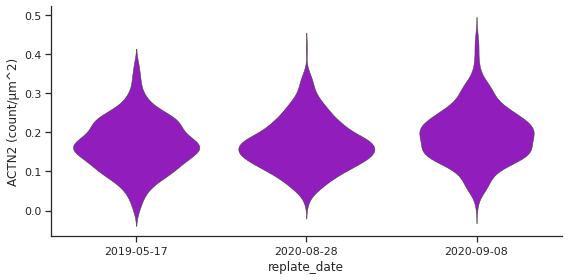

In [87]:
sns.catplot(
    kind="violin",
    split=True,
    data=actn2_df[actn2_df.Type=="FISH"],
    x="replate_date",
    y="ACTN2 (count/μm^2)",
    color=DAY_25_COLOR,
    height=4,
    aspect=2,
    inner=None,
    linewidth=0.5,
    order=["2019-05-17", "2020-08-28", "2020-09-08"]
)
sns.despine()


# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'supp_fig5d_actn2_transcript_density_replate.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'supp_fig5d_actn2_transcript_density_replate.svg', format="svg", bbox_inches = "tight")

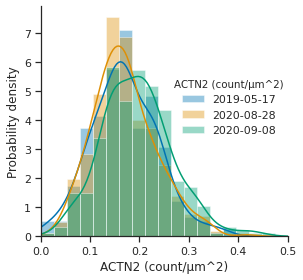

In [88]:
bins = np.linspace(0,0.5,20)

g = sns.FacetGrid(
    actn2_df[actn2_df.Type=="FISH"],
    hue='replate_date',
    hue_order=["2019-05-17", "2020-08-28", "2020-09-08"],
    height=4,
    palette=sns.color_palette("colorblind")
)
g = g.map(
    sns.distplot,
    'ACTN2 (count/μm^2)',
    bins=bins
).add_legend()

g.set(xlim=(0, 0.5));
g._legend.set(bbox_to_anchor=(0.75, 0.6))
g._legend.set_title("ACTN2 (count/μm^2)")
g.set(ylabel='Probability density');

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'supp_fig5d_actn2_transcript_density_replate_hist.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'supp_fig5d_actn2_transcript_density_replate_hist.svg', format="svg", bbox_inches = "tight")

### Supp Figure 6

### bar plots

/home/tanyag/anaconda3/envs/cardio_fish_data/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


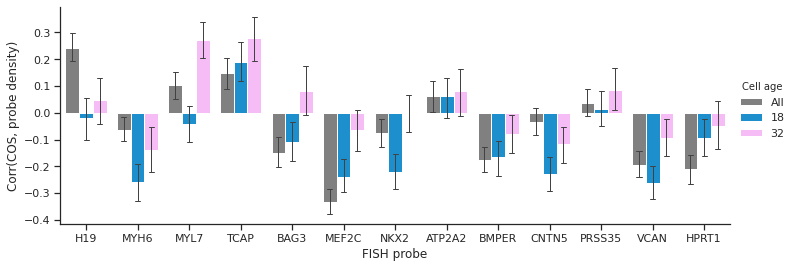

In [89]:
df_fish_tidy_dummy_all = df_fish_tidy.copy()
df_fish_tidy_dummy_all["Cell age"] = "All"
df_fish_tidy_dummy_all = df_fish_tidy_dummy_all.append(df_fish_tidy).reset_index(drop=True)

pack_complex_corr_col(
    df_fish_tidy_dummy_all,
    "Combined organizational score",
    "FISH probe (count/μm^2)",
    outcol="Corr(COS, probe density)",
)

plt.figure(figsize=(12, 4))
sns.barplot(
    data=df_fish_tidy_dummy_all[df_fish_tidy_dummy_all["Cell age"].isin(["All", 18, 32])].dropna(subset=["Combined organizational score", "FISH probe (count/μm^2)"]),
    x="FISH probe",
    y="Corr(COS, probe density)",
    order=['H19', 'MYH6', 'MYL7', 'TCAP', 'BAG3', 'MEF2C', 'NKX2', 'ATP2A2', 'BMPER', 'CNTN5', 'PRSS35', 'VCAN', 'HPRT1'],
    hue="Cell age",
    hue_order=["All", 18, 32],
    palette=DAY_COLOR_PALETTE_2_PLUS_GREY,
    estimator=spearman_on_complex_col,
    n_boot=1000,
    ci=95,
    errwidth=1,
    capsize=0.1,
    dodge=True,
);
sns.despine();
plt.legend(title="Cell age", bbox_to_anchor=(1.0, 0.7), frameon=False);

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'supp_fig6a_probe_density_vs_org_score_by_day.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'supp_fig6a_probe_density_vs_org_score_by_day.svg', format="svg", bbox_inches = "tight")

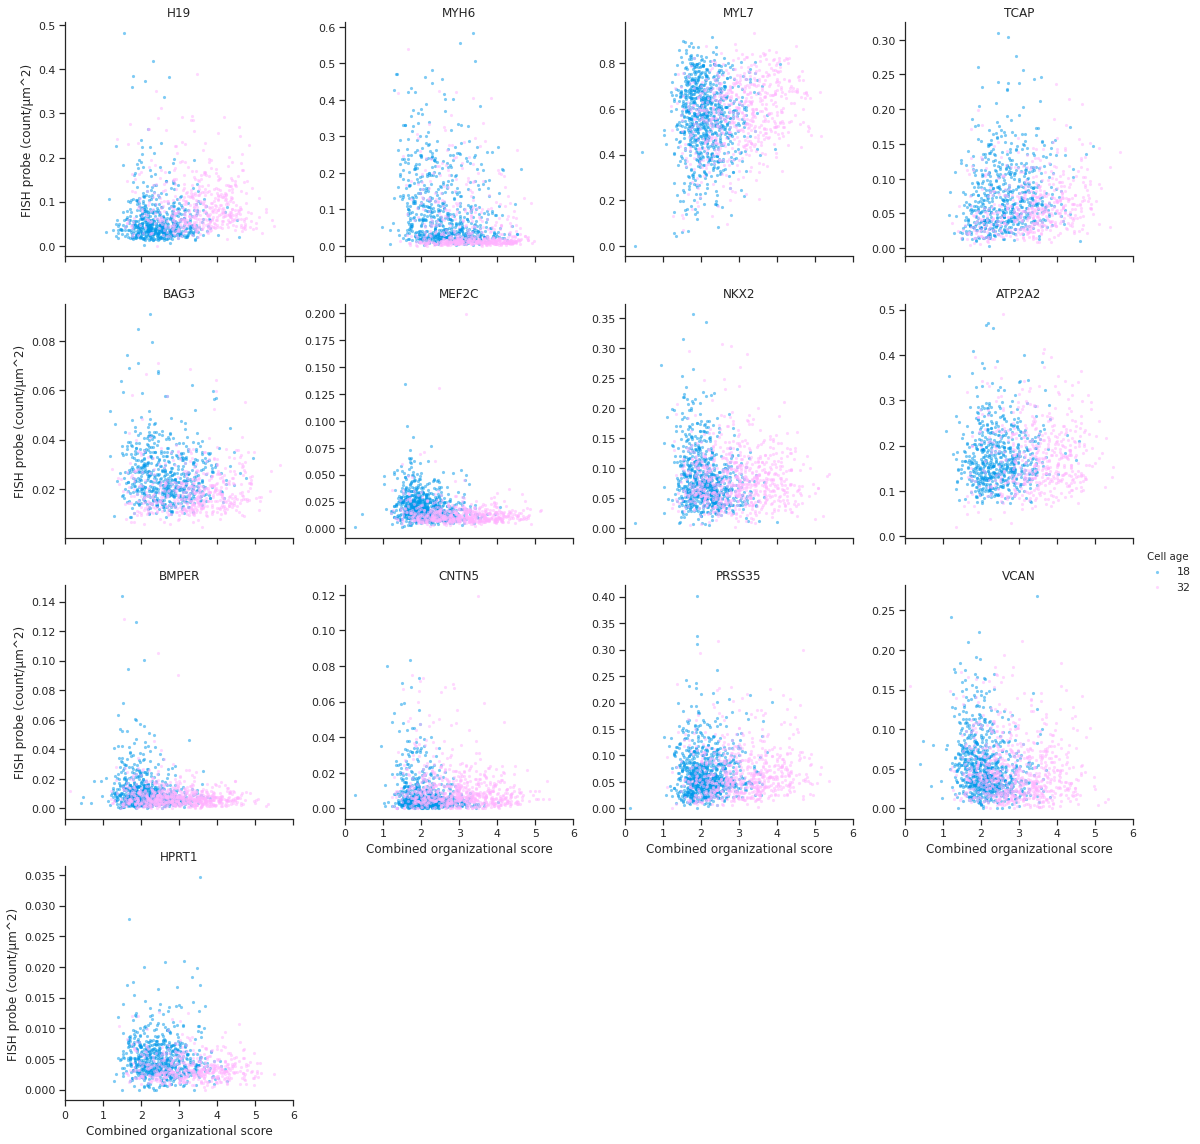

In [90]:
g = sns.FacetGrid(
    data=df_fish_tidy[df_fish_tidy["Cell age"].isin([18, 32])].sample(frac=1, replace=False).reset_index(drop=True),
    col="FISH probe",
    col_order=['H19', 'MYH6', 'MYL7', 'TCAP', 'BAG3', 'MEF2C', 'NKX2', 'ATP2A2', 'BMPER', 'CNTN5', 'PRSS35', 'VCAN', 'HPRT1'],
    col_wrap=4,
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    sharex=True,
    xlim=(0,6),
    sharey=False,
    height=4.0,
    aspect=1.0,
)

g = g.map(
    plt.scatter,
    "Combined organizational score",
    "FISH probe (count/μm^2)",
    s=10,
    alpha=0.5,
    linewidth=0,
).add_legend()

g.set_titles("{col_name}")

sns.despine()

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'supp_fig6b_probe_density_vs_org_score.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'supp_fig6b_probe_density_vs_org_score.svg', format="svg", bbox_inches = "tight")

Save each scatter separately

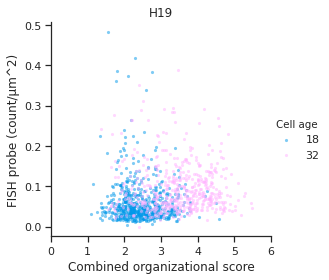

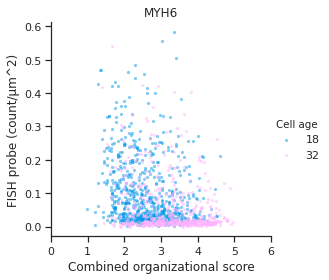

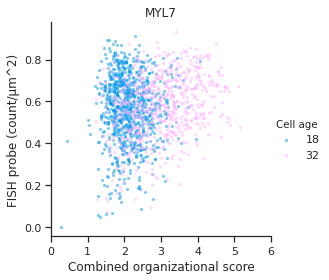

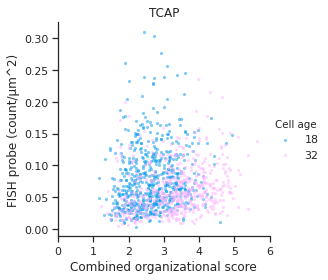

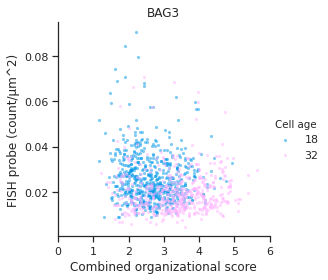

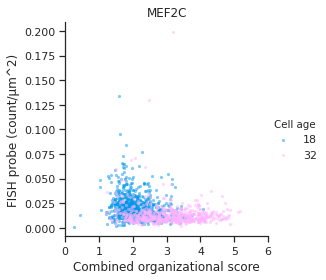

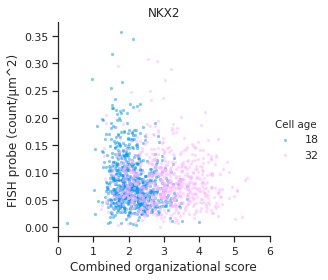

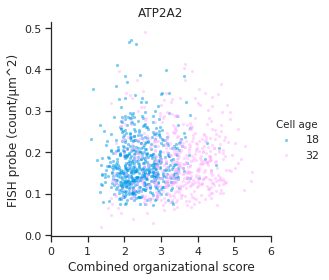

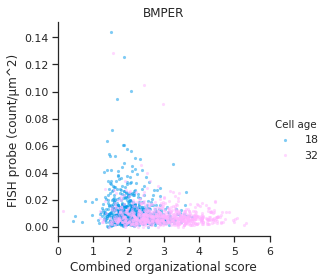

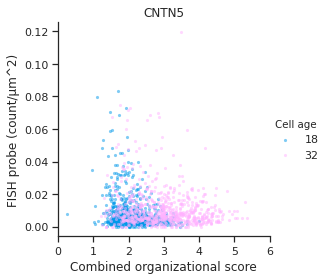

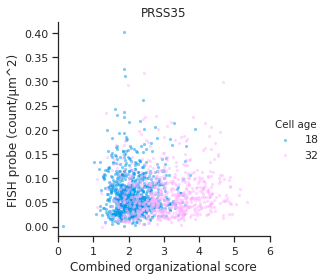

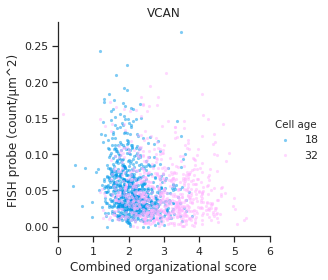

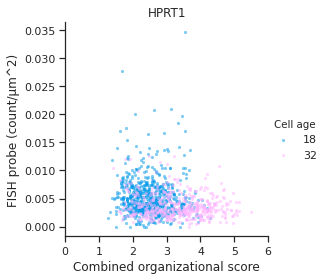

In [91]:
probes = ['H19', 'MYH6', 'MYL7', 'TCAP', 'BAG3', 'MEF2C', 'NKX2', 'ATP2A2', 'BMPER', 'CNTN5', 'PRSS35', 'VCAN', 'HPRT1']
for p in probes:
    g = sns.FacetGrid(
        data=df_fish_tidy[df_fish_tidy["Cell age"].isin([18, 32])].sample(frac=1, replace=False).reset_index(drop=True),
        col="FISH probe",
        col_order=[p],
        col_wrap=1,
        hue="Cell age",
        hue_order=[18, 32],
        palette=DAY_COLOR_PALETTE,
        sharex=True,
        xlim=(0,6),
        sharey=False,
        height=4.0,
        aspect=1.0,
    )

    g = g.map(
        plt.scatter,
        "Combined organizational score",
        "FISH probe (count/μm^2)",
        s=10,
        alpha=0.5,
        linewidth=0,
    ).add_legend()

    g.set_titles("{col_name}")

    sns.despine()

    # save png and svg
    if SAVE:
        plt.savefig(save_dir_pngs/f'supp_fig6b_probe_density_vs_org_score_{p}.png', dpi=300, bbox_inches = "tight")
        plt.savefig(save_dir_svgs/f'supp_fig6b_probe_density_vs_org_score_{p}.svg', format="svg", bbox_inches = "tight")

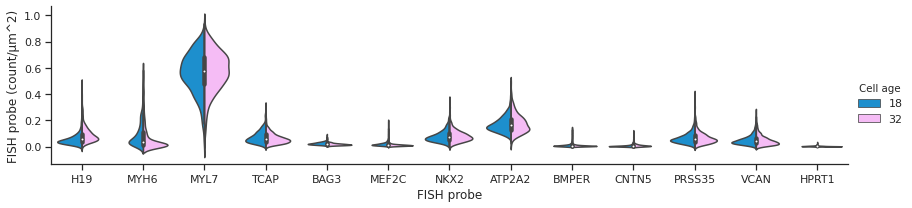

In [92]:
sns.catplot(
    kind="violin",
    split=True,
    data=df_fish_tidy[df_fish_tidy["Cell age"].isin([18, 32])],
    x="FISH probe",
    order=['H19', 'MYH6', 'MYL7', 'TCAP', 'BAG3', 'MEF2C', 'NKX2', 'ATP2A2', 'BMPER', 'CNTN5', 'PRSS35', 'VCAN', 'HPRT1'],
    y="FISH probe (count/μm^2)",
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    height=3,
    aspect=4,
)
sns.despine()

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'supp_fig6c_probe_density_violins.png', dpi=300, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'supp_fig6c_probe_density_violins.svg', format="svg", bbox_inches = "tight")

Calculate normalized myh6/7 difference

In [93]:
df_myh67 = (
    df[df["Cell age"].isin([18, 32])].dropna(subset=["MYH6 (count/μm^2)", "MYH7 (count/μm^2)"])
    .reset_index(drop=True)
    )

In [94]:
# add normalized difference metric to data frame ~ (MYH7-MYH6)/(MYH7+MYH6)
df_myh67["MYH7-MYH6 relative transcript abundance (normalized)"] = (
    df_myh67["MYH7 (count/μm^2)"] / df["MYH7 (count/μm^2)"].dropna().median()
    - df_myh67["MYH6 (count/μm^2)"] / df["MYH6 (count/μm^2)"].dropna().median()
) / (
    df_myh67["MYH7 (count/μm^2)"] / df["MYH7 (count/μm^2)"].dropna().median()
    + df_myh67["MYH6 (count/μm^2)"] / df["MYH6 (count/μm^2)"].dropna().median()
)

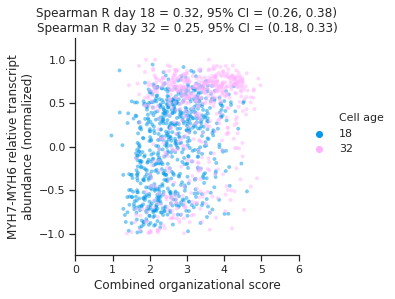

In [95]:
x = "Combined organizational score"
y = "MYH7-MYH6 relative transcript abundance (normalized)"
stratify = "Cell age"

plt.figure(figsize=(4, 4))

plot_myh67_vs_org_score = sns.scatterplot(
    data=df_myh67.dropna(subset=[x,y]),
    x=x,
    y=y,
    hue=stratify,
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    linewidth=0,
    alpha = 0.5,
    s=15
)
plot_myh67_vs_org_score.set(
    xlim=(0, 6),
    ylim=(-1.25, 1.25),
    ylabel=y.replace("transcript abundance", "transcript\nabundance")
);

handles, _ = plot_myh67_vs_org_score.get_legend_handles_labels()
plot_myh67_vs_org_score.legend(handles, ["Cell age", "18", "32"], bbox_to_anchor=(1.0, 0.7), frameon=False)


df_boot_spr = boot_spearmanr(df_myh67, x=x, y=y, stratify=stratify, N=1000)

mean_col = f"Spearman R ({x}, {y}) (mean)"
hi_col = f"Spearman R ({x}, {y}) (CI high)"
low_col = f"Spearman R ({x}, {y}) (CI low)"

title = "\n".join([
    f"Spearman R day {day} = {row[mean_col]:.2f}, 95% CI = ({row[low_col]:.2f}, {row[hi_col]:.2f})"
    for day, row in df_boot_spr.set_index(stratify).iterrows()
])

plt.title(title)

sns.despine()

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'supp_fig_6d_linear_model_vs_myh_diff_scatter.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'supp_fig_6d_linear_model_vs_myh_diff_scatter.svg', format="svg", bbox_inches = "tight")

In [96]:
df_dummy = pd.concat([df_myh67,pd.DataFrame(np.zeros(len(df_myh67)), columns=["MYH67 vs org score all cells"])], axis=1)
boot_spearmanr(df_dummy, x=x, y=y, stratify="MYH67 vs org score all cells", N=1000)

MYH67 vs org score all cells  \
0                          0.0   

   Spearman R (Combined organizational score, MYH7-MYH6 relative transcript abundance (normalized)) (mean)  \
0                                           0.388931                                                         

   Spearman R (Combined organizational score, MYH7-MYH6 relative transcript abundance (normalized)) (CI low)  \
0                                           0.340924                                                           

   Spearman R (Combined organizational score, MYH7-MYH6 relative transcript abundance (normalized)) (CI high)  
0                                            0.43299

Dist plots

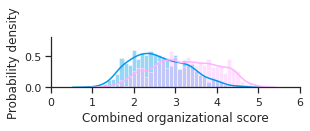

In [97]:
bins = np.linspace(0,6,61)
bins -= (bins[1]-bins[0])/2

g = sns.FacetGrid(
    data=df_myh67,
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    height=1.5,
    aspect=2.75,
)
g = g.map(
    sns.distplot,
    "Combined organizational score",
    bins=bins,
    kde_kws=dict(bw=0.15)
)
g.set(ylabel='Probability density')
g.set(xlim=(0, 6));
g.set(ylim=(0, 0.8));

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'supp_fig_6d_linear_model_vs_myh_diff_top_hist.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'supp_fig_6d_linear_model_vs_myh_diff_top_hist.svg', format="svg", bbox_inches = "tight")

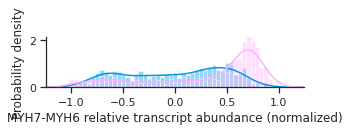

In [98]:
bins = np.linspace(-1.25, 1.25,61)
bins -= (bins[1]-bins[0])/2

g = sns.FacetGrid(
    data=df_myh67,
    hue="Cell age",
    hue_order=[18, 32],
    palette=DAY_COLOR_PALETTE,
    height=1.5,
    aspect=2.75,
)
g = g.map(
    sns.distplot,
    "MYH7-MYH6 relative transcript abundance (normalized)",
    bins=bins,
    kde_kws=dict(bw=0.1)
)
g.set(ylabel='Probability density')
g.set(xlim=(-1.25, 1.25));
g.set(ylim=(0, 2.1));

# save png and svg
if SAVE:
    plt.savefig(save_dir_pngs/'supp_fig_6d_linear_model_vs_myh_diff_right_hist.png', dpi=100, bbox_inches = "tight")
    plt.savefig(save_dir_svgs/'supp_fig_6d_linear_model_vs_myh_diff_right_hist.svg', format="svg", bbox_inches = "tight")